<a href="https://colab.research.google.com/github/mille055/stanford_project/blob/dockerversion/app/notebooks/Stanford_CS231N.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
COLAB_FLAG = True   # whether running on colab or locally on computer

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
if COLAB_FLAG:
  %pip install pydicom==2.1.2
  %pip install monai seaborn sentence_transformers
  !git clone -b dockerversion 'https://github.com/mille055/stanford_project.git'
  

    

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 34.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 107.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.0 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=0a42728fc402171bdb2c9411327cea67bb07a4a8ef392d6e5c475c482eb58f4a
  Stored in directory: 

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import torchvision
import pydicom
import pickle
import glob
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

import seaborn as sns
from datetime import datetime

from sentence_transformers import SentenceTransformer

from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time
import os
import copy
from pprint import pprint
from fastai.basics import delegates
from fastcore.parallel import parallel
from fastcore.utils import gt
from fastcore.foundation import L

from pydicom.dataset import Dataset as DcmDataset
from pydicom.tag import BaseTag as DcmTag
from pydicom.multival import MultiValue as DcmMultiValue
import sys
import importlib
import warnings
from google.colab import drive
warnings.filterwarnings("ignore")

In [5]:
#local imports
if COLAB_FLAG:
    sys.path.append('/content/stanford_project/app/scripts/')
    train_datafile = '/content/stanford_project/app/data/trainfiles.csv'
    val_datafile = '/content/stanford_project/app/data/valfiles.csv'
    test_datafile = '/content/stanford_project/app/data/testfiles.csv'
    
    drive.mount('/content/gdrive')

else: # running locally
    sys.path.append('/Users/cmm/Documents/GitHub/new/stanford_project/app/scripts/')
    #sys.path.append('/workspaces/stanford_project/app/scripts/')
    train_datafile = '../data/trainfiles.csv'
    val_datafile = '../data/valfiles.csv'
    test_datafile = '../data/testfiles.csv'


### local imports ###
from config import file_dict, feats, feats_to_keep, column_lists, RF_parameters, classes, model_paths
from config import abd_label_dict, val_list, train_val_split_percent, random_seed, data_transforms
from config import sentence_encoder, series_description_column
from utils import *

from cnn.cnn_dataset import ImgDataset
from cnn.cnn_inference import image_to_tensor, pixel_inference, test_pix_model, load_pixel_model, visualize_results
from cnn.cnn_model import *
from cnn.cnn_training import *
from cnn.cnn_data_loaders import get_data_loaders, data_transforms, data_transforms2

from model_container import ModelContainer



Mounted at /content/gdrive


In [6]:


train_df, val_df, test_df = create_datasets(train_datafile, val_datafile, test_datafile, '/volumes/cm7/Abdominal_MRI_dataset_split/', '/content/gdrive/MyDrive/WW_MRI_abd2/split/' )



In [7]:
sorted(val_df.label.unique())

[0, 2, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 23, 25]

In [8]:
# Get the data loaders
batch_size = 16
train_loader, val_loader, test_loader, dataset_sizes = get_data_loaders(train_df, val_df, test_df, batch_size)
train_loader2, val_loader2, test_loader2, dataset_sizes2 = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=data_transforms2)
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataloaders2 = {'train': train_loader2, 'val': val_loader2, 'test': test_loader2}

In [9]:
# Different combinations to evaluate
models = [CustomResNet50, CustomResNet50b, CustomDenseNet]
loss_funcs = [nn.CrossEntropyLoss, FocalLoss]
loaders = ['dataloaders', 'dataloaders2']
loaders_dict = {'dataloaders': dataloaders, 'dataloaders2': dataloaders2}
optimizers = ['SGD', 'Adam']
optim_dict = {
    'SGD': {
        'class': torch.optim.SGD,
        'params': {'lr': 0.001, 'momentum': 0.9}
    },
    'Adam': {
        'class': torch.optim.Adam,
        'params': {'lr': 0.001, 'betas': (0.9, 0.999)}
    }
}



Training with CustomResNet50, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7ffaab317790>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7ffaab317850>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7ffaab317460>}, SGD, CrossEntropyLoss


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 332MB/s]


Epoch 0/14
----------
train Loss: 1.9926 Acc: 0.3820
val Loss: 1.3043 Acc: 0.6186

Epoch 1/14
----------
train Loss: 0.8960 Acc: 0.7626
val Loss: 0.8656 Acc: 0.7373

Epoch 2/14
----------
train Loss: 0.5546 Acc: 0.8408
val Loss: 0.6997 Acc: 0.7853

Epoch 3/14
----------
train Loss: 0.3578 Acc: 0.9072
val Loss: 0.6315 Acc: 0.8023

Epoch 4/14
----------
train Loss: 0.2284 Acc: 0.9503
val Loss: 0.6504 Acc: 0.7910

Epoch 5/14
----------
train Loss: 0.1690 Acc: 0.9613
val Loss: 0.6490 Acc: 0.7994

Epoch 6/14
----------
train Loss: 0.1079 Acc: 0.9861
val Loss: 0.6271 Acc: 0.7966

Epoch 7/14
----------
train Loss: 0.0824 Acc: 0.9912
val Loss: 0.6143 Acc: 0.8023

Epoch 8/14
----------
train Loss: 0.0843 Acc: 0.9861
val Loss: 0.6249 Acc: 0.8136

Epoch 9/14
----------
train Loss: 0.0680 Acc: 0.9920
val Loss: 0.6146 Acc: 0.8107

Epoch 10/14
----------
train Loss: 0.0688 Acc: 0.9927
val Loss: 0.6057 Acc: 0.8136

Epoch 11/14
----------
train Loss: 0.0718 Acc: 0.9927
val Loss: 0.6149 Acc: 0.8136

Ep

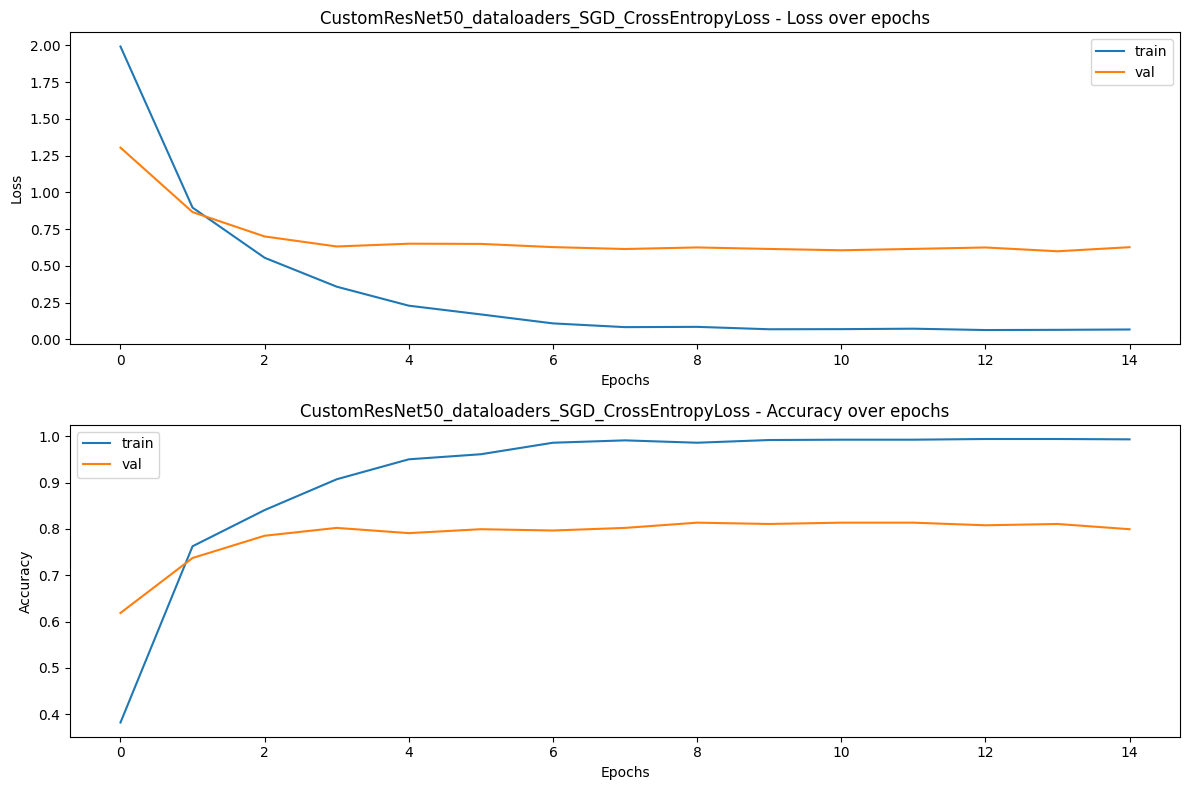


Training with CustomResNet50, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7ffaab317790>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7ffaab317850>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7ffaab317460>}, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 1.4673 Acc: 0.4463
val Loss: 0.8169 Acc: 0.6469

Epoch 1/14
----------
train Loss: 0.4949 Acc: 0.7736
val Loss: 0.4901 Acc: 0.7627

Epoch 2/14
----------
train Loss: 0.2697 Acc: 0.8736
val Loss: 0.4382 Acc: 0.8023

Epoch 3/14
----------
train Loss: 0.1606 Acc: 0.9189
val Loss: 0.3885 Acc: 0.7938

Epoch 4/14
----------
train Loss: 0.0991 Acc: 0.9445
val Loss: 0.4065 Acc: 0.8023

Epoch 5/14
----------
train Loss: 0.0707 Acc: 0.9620
val Loss: 0.3677 Acc: 0.8107

Epoch 6/14
----------
train Loss: 0.0370 Acc: 0.9869
val Loss: 0.4047 Acc: 0.8023

Epoch 7/14
----------
train Loss: 0.0334 Acc: 0.9898
val Loss: 0.3721 Acc: 0.8107

Epoch 8/14
----------
train Loss: 0.0290 Acc: 0.9942
val Loss: 

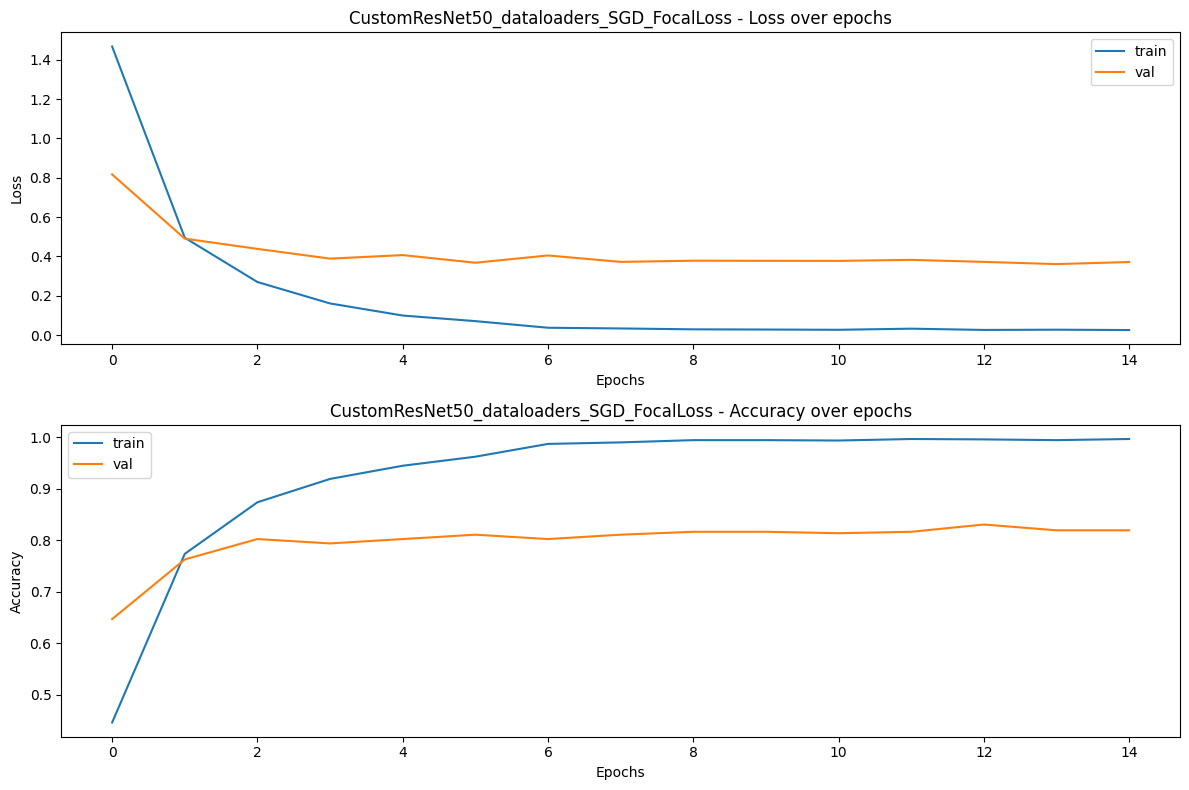


Training with CustomResNet50, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7ffaab317790>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7ffaab317850>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7ffaab317460>}, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.7338 Acc: 0.4551
val Loss: 2.9921 Acc: 0.2938

Epoch 1/14
----------
train Loss: 1.2523 Acc: 0.5800
val Loss: 2.6665 Acc: 0.4153

Epoch 2/14
----------
train Loss: 1.0501 Acc: 0.6508
val Loss: 1.2483 Acc: 0.6215

Epoch 3/14
----------
train Loss: 0.9243 Acc: 0.7056
val Loss: 1.1971 Acc: 0.6073

Epoch 4/14
----------
train Loss: 0.7832 Acc: 0.7312
val Loss: 4.6911 Acc: 0.3249

Epoch 5/14
----------
train Loss: 0.6211 Acc: 0.7925
val Loss: 1.4374 Acc: 0.6554

Epoch 6/14
----------
train Loss: 0.6398 Acc: 0.7933
val Loss: 2.0130 Acc: 0.5537

Epoch 7/14
----------
train Loss: 0.4766 Acc: 0.8320
val Loss: 0.8291 Acc: 0.7429

Epoch 8/14
----------
train Loss: 0.3102 Acc: 0.9028
va

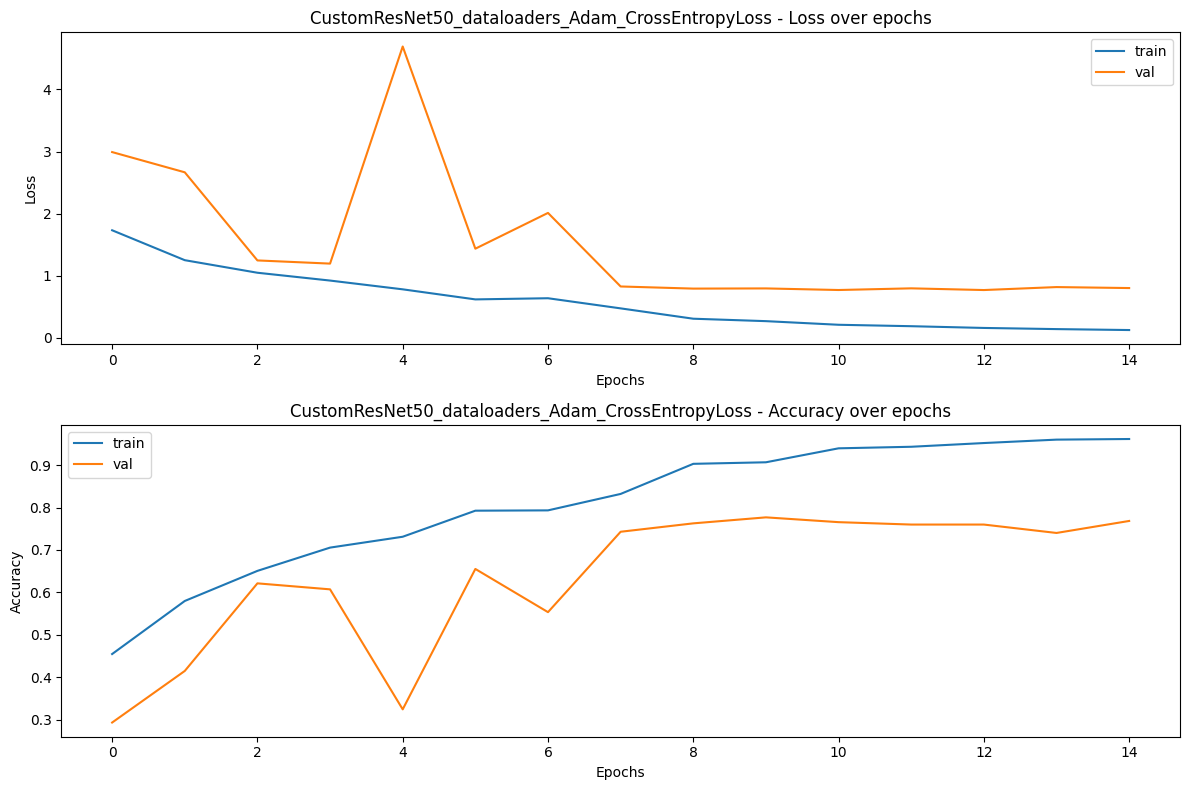


Training with CustomResNet50, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7ffaab317790>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7ffaab317850>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7ffaab317460>}, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.4334 Acc: 0.4069
val Loss: 2.5702 Acc: 0.3362

Epoch 1/14
----------
train Loss: 0.8462 Acc: 0.5588
val Loss: 1.1669 Acc: 0.4831

Epoch 2/14
----------
train Loss: 0.7645 Acc: 0.6048
val Loss: 2.0017 Acc: 0.3588

Epoch 3/14
----------
train Loss: 0.7059 Acc: 0.6085
val Loss: 1.3080 Acc: 0.4548

Epoch 4/14
----------
train Loss: 0.5270 Acc: 0.6932
val Loss: 1.4328 Acc: 0.5085

Epoch 5/14
----------
train Loss: 0.4646 Acc: 0.7290
val Loss: 0.9396 Acc: 0.6271

Epoch 6/14
----------
train Loss: 0.4210 Acc: 0.7480
val Loss: 1.1098 Acc: 0.5734

Epoch 7/14
----------
train Loss: 0.2722 Acc: 0.8327
val Loss: 0.5755 Acc: 0.7147

Epoch 8/14
----------
train Loss: 0.1793 Acc: 0.8831
val Loss:

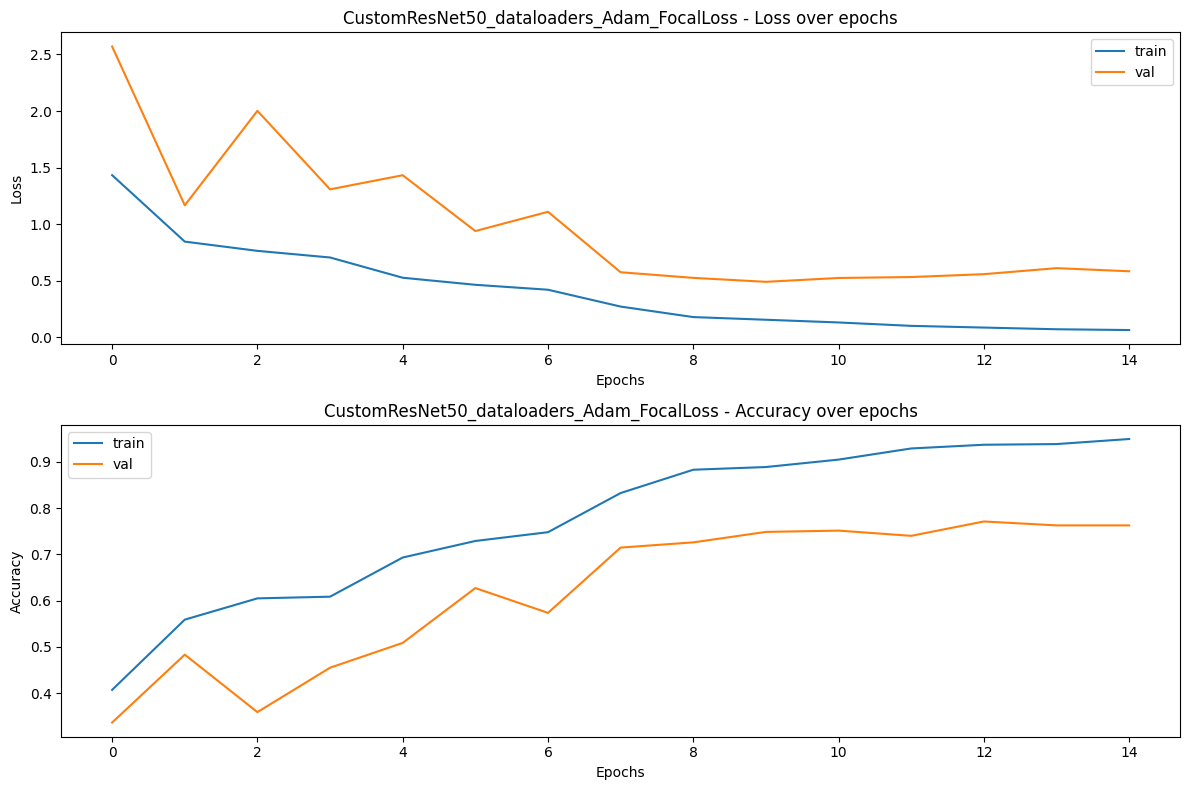


Training with CustomResNet50, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7ffaa3ad1ab0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7ffaa3ad0490>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7ffaa3f51f00>}, SGD, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 2.0201 Acc: 0.3959
val Loss: 1.3848 Acc: 0.5763

Epoch 1/14
----------
train Loss: 1.0299 Acc: 0.6969
val Loss: 0.9008 Acc: 0.7090

Epoch 2/14
----------
train Loss: 0.6573 Acc: 0.8174
val Loss: 0.7419 Acc: 0.7599

Epoch 3/14
----------
train Loss: 0.4713 Acc: 0.8576
val Loss: 0.6224 Acc: 0.7966

Epoch 4/14
----------
train Loss: 0.3409 Acc: 0.8999
val Loss: 0.5660 Acc: 0.8249

Epoch 5/14
----------
train Loss: 0.2708 Acc: 0.9306
val Loss: 0.5280 Acc: 0.8277

Epoch 6/14
----------
train Loss: 0.1890 Acc: 0.9613
val Loss: 0.5581 Acc: 0.8164

Epoch 7/14
----------
train Loss: 0.1490 Acc: 0.9664
val Loss: 0.5183 Acc: 0.8305

Epoch 8/14
----------
train Loss: 0.1360 Acc: 0.9774
val

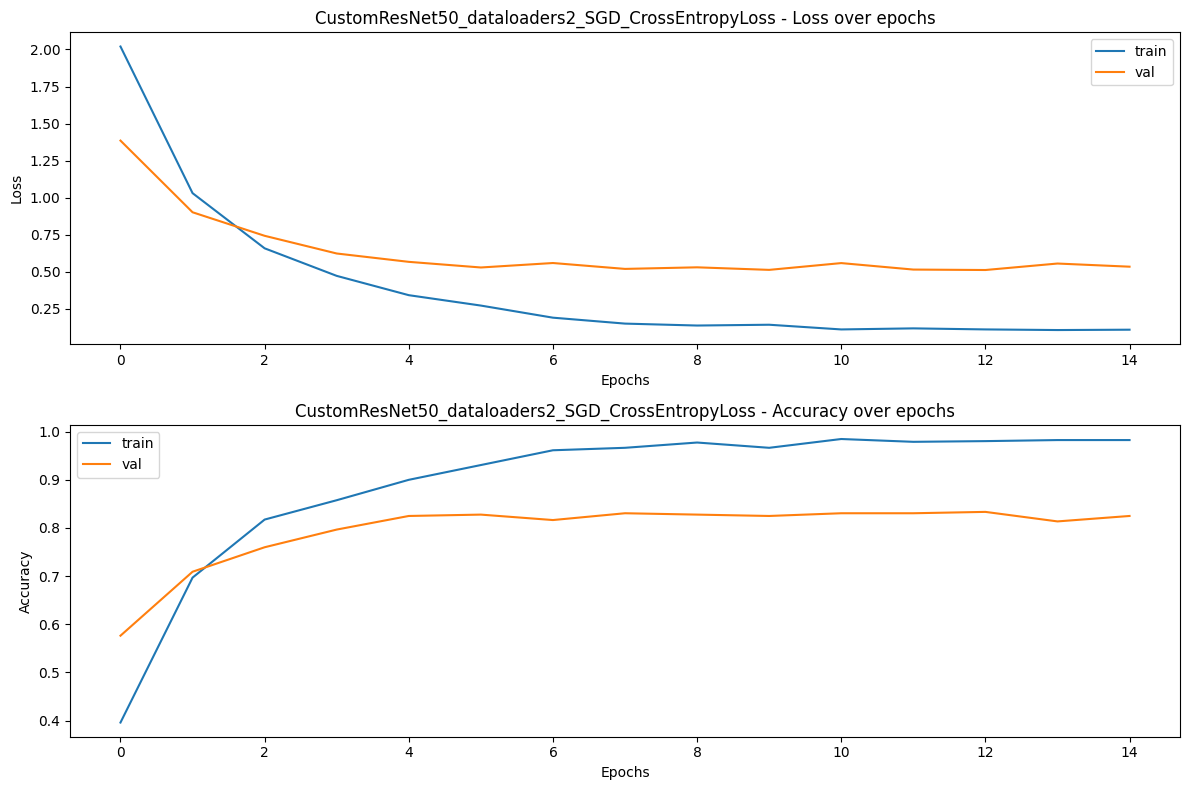


Training with CustomResNet50, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7ffaa3ad1ab0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7ffaa3ad0490>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7ffaa3f51f00>}, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 1.5743 Acc: 0.4032
val Loss: 0.8677 Acc: 0.6243

Epoch 1/14
----------
train Loss: 0.6064 Acc: 0.7290
val Loss: 0.5921 Acc: 0.7429

Epoch 2/14
----------
train Loss: 0.3714 Acc: 0.8035
val Loss: 0.4721 Acc: 0.7599

Epoch 3/14
----------
train Loss: 0.2641 Acc: 0.8554
val Loss: 0.4148 Acc: 0.8051

Epoch 4/14
----------
train Loss: 0.1694 Acc: 0.9043
val Loss: 0.3736 Acc: 0.8079

Epoch 5/14
----------
train Loss: 0.1252 Acc: 0.9423
val Loss: 0.3912 Acc: 0.8136

Epoch 6/14
----------
train Loss: 0.0855 Acc: 0.9554
val Loss: 0.3609 Acc: 0.8305

Epoch 7/14
----------
train Loss: 0.0549 Acc: 0.9774
val Loss: 0.3694 Acc: 0.8164

Epoch 8/14
----------
train Loss: 0.0527 Acc: 0.9774
val Loss: 

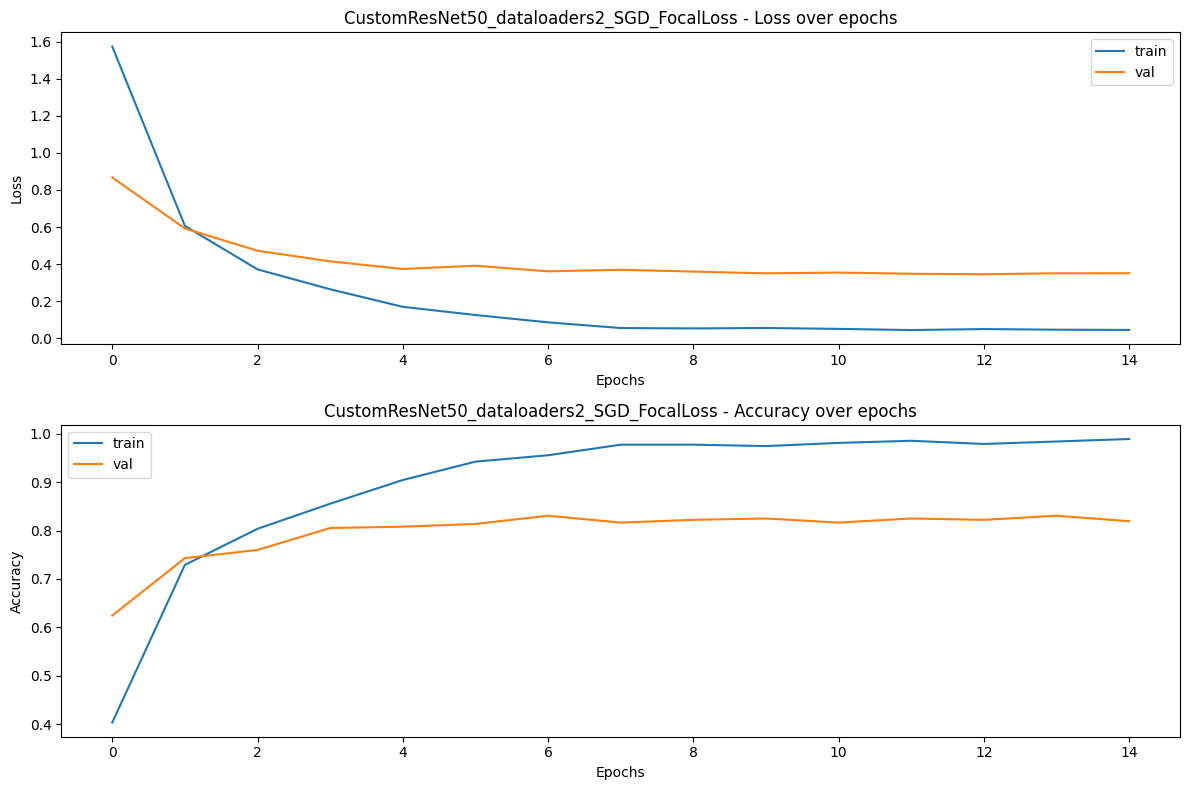


Training with CustomResNet50, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7ffaa3ad1ab0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7ffaa3ad0490>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7ffaa3f51f00>}, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.9454 Acc: 0.3638
val Loss: 3.5973 Acc: 0.2655

Epoch 1/14
----------
train Loss: 1.4881 Acc: 0.4953
val Loss: 1.6334 Acc: 0.4153

Epoch 2/14
----------
train Loss: 1.2818 Acc: 0.5530
val Loss: 2.0582 Acc: 0.3814

Epoch 3/14
----------
train Loss: 1.1713 Acc: 0.5829
val Loss: 1.3031 Acc: 0.5593

Epoch 4/14
----------
train Loss: 1.0345 Acc: 0.6377
val Loss: 1.3449 Acc: 0.5593

Epoch 5/14
----------
train Loss: 0.9078 Acc: 0.6896
val Loss: 1.4312 Acc: 0.6045

Epoch 6/14
----------
train Loss: 0.8199 Acc: 0.7195
val Loss: 1.3388 Acc: 0.5876

Epoch 7/14
----------
train Loss: 0.6032 Acc: 0.8006
val Loss: 0.8874 Acc: 0.7147

Epoch 8/14
----------
train Loss: 0.4878 Acc: 0.8298
va

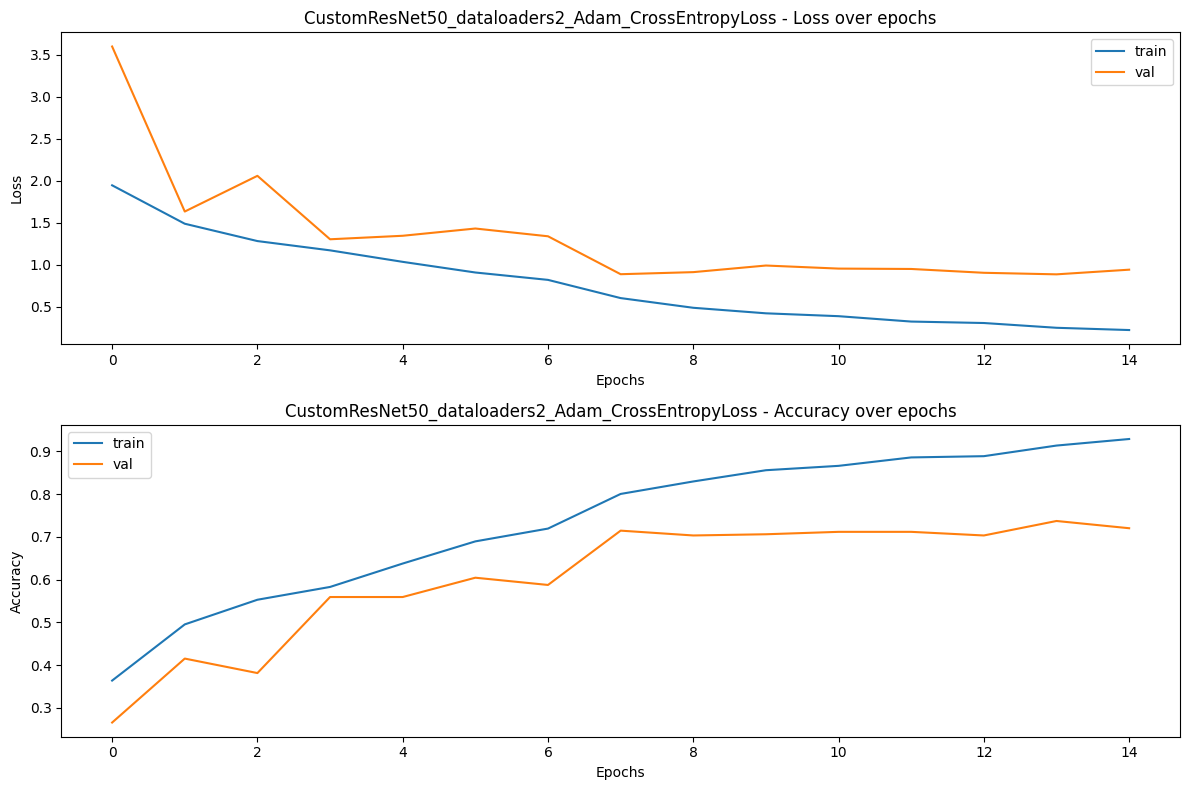


Training with CustomResNet50, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7ffaa3ad1ab0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7ffaa3ad0490>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7ffaa3f51f00>}, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.4764 Acc: 0.3915
val Loss: 2.9170 Acc: 0.3051

Epoch 1/14
----------
train Loss: 1.0399 Acc: 0.4989
val Loss: 1.5738 Acc: 0.4124

Epoch 2/14
----------
train Loss: 0.7828 Acc: 0.5902
val Loss: 1.2538 Acc: 0.4350

Epoch 3/14
----------
train Loss: 0.6758 Acc: 0.6413
val Loss: 0.9654 Acc: 0.5706

Epoch 4/14
----------
train Loss: 0.6035 Acc: 0.6589
val Loss: 1.0514 Acc: 0.5395

Epoch 5/14
----------
train Loss: 0.5169 Acc: 0.7005
val Loss: 0.8486 Acc: 0.6271

Epoch 6/14
----------
train Loss: 0.4707 Acc: 0.7064
val Loss: 1.7973 Acc: 0.4972

Epoch 7/14
----------
train Loss: 0.2789 Acc: 0.8247
val Loss: 0.5392 Acc: 0.7147

Epoch 8/14
----------
train Loss: 0.1973 Acc: 0.8678
val Loss:

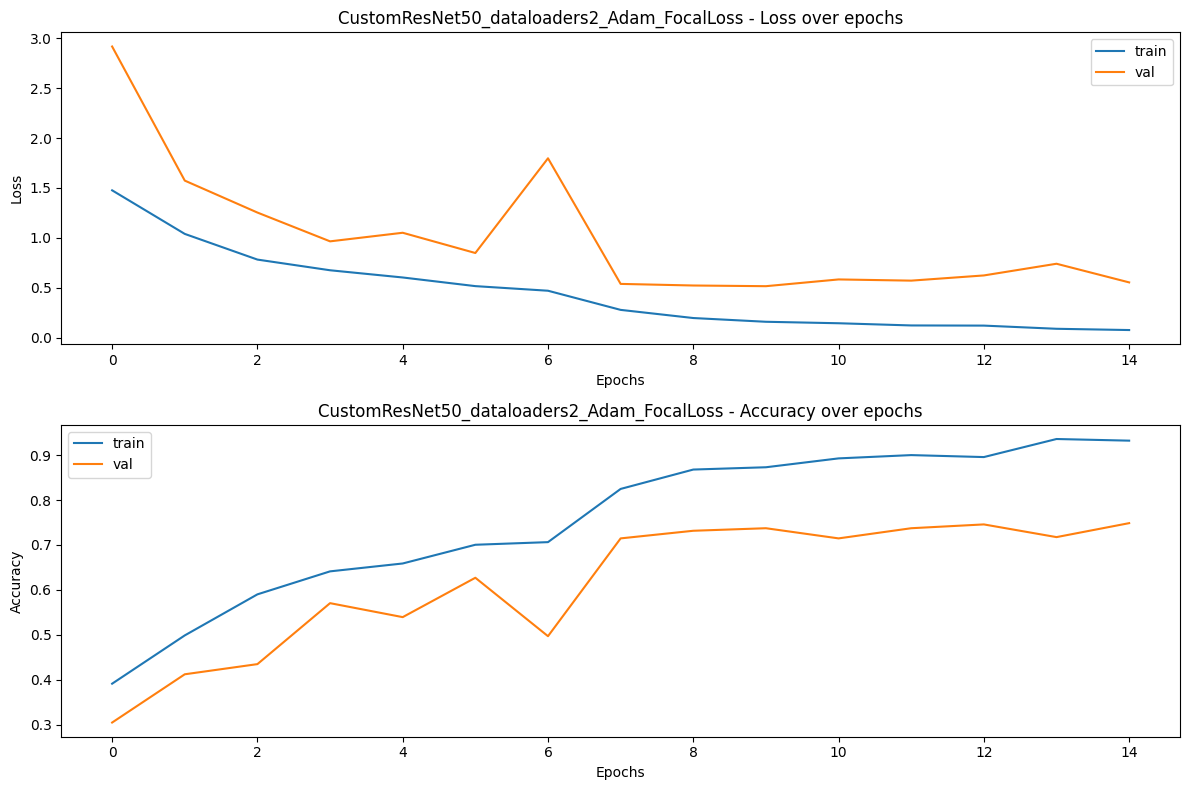


Training with CustomResNet50b, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7ffaab317790>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7ffaab317850>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7ffaab317460>}, SGD, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 2.5278 Acc: 0.2009
val Loss: 2.1031 Acc: 0.3588

Epoch 1/14
----------
train Loss: 1.7158 Acc: 0.5062
val Loss: 1.3877 Acc: 0.5989

Epoch 2/14
----------
train Loss: 1.0929 Acc: 0.6896
val Loss: 1.0091 Acc: 0.6751

Epoch 3/14
----------
train Loss: 0.7426 Acc: 0.7823
val Loss: 0.8137 Acc: 0.7684

Epoch 4/14
----------
train Loss: 0.5145 Acc: 0.8561
val Loss: 0.7391 Acc: 0.7740

Epoch 5/14
----------
train Loss: 0.3762 Acc: 0.8941
val Loss: 0.6537 Acc: 0.7966

Epoch 6/14
----------
train Loss: 0.2989 Acc: 0.9145
val Loss: 0.6079 Acc: 0.7966

Epoch 7/14
----------
train Loss: 0.2193 Acc: 0.9489
val Loss: 0.5960 Acc: 0.8192

Epoch 8/14
----------
train Loss: 0.2185 Acc: 0.9511
va

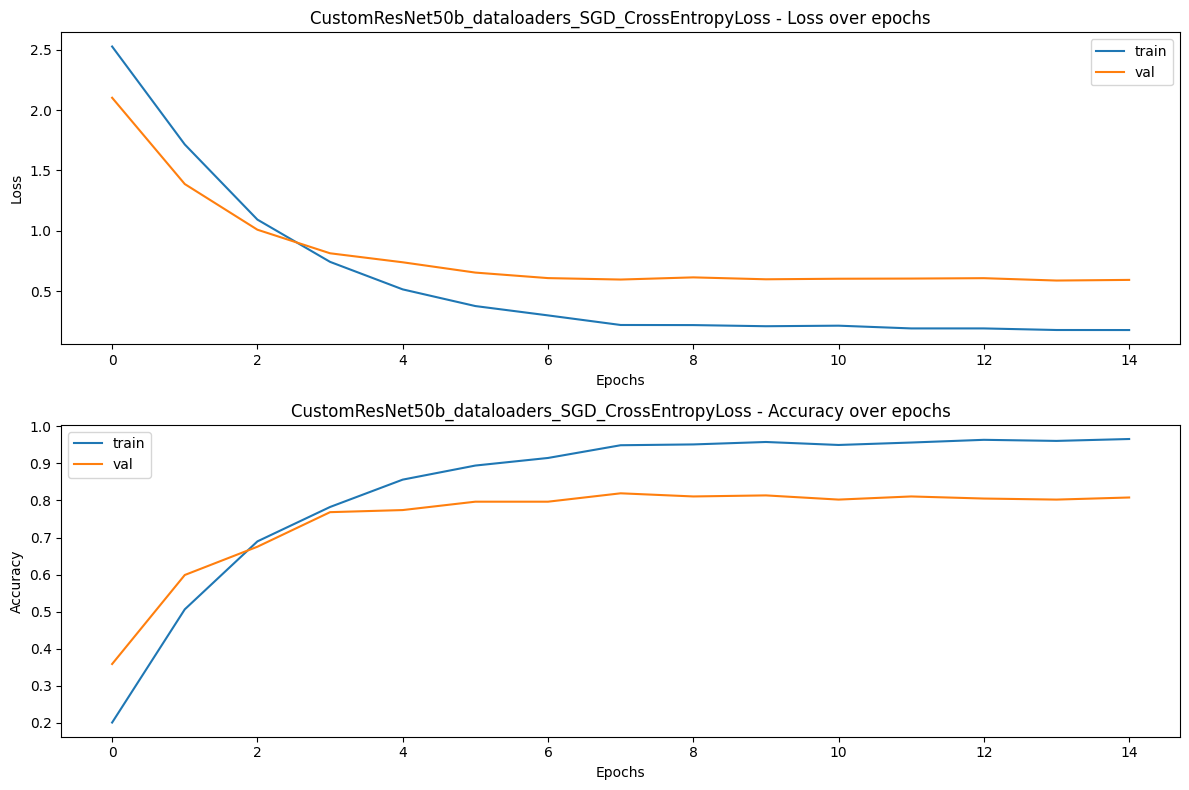


Training with CustomResNet50b, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7ffaab317790>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7ffaab317850>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7ffaab317460>}, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 2.0666 Acc: 0.2425
val Loss: 1.5797 Acc: 0.3898

Epoch 1/14
----------
train Loss: 1.1137 Acc: 0.5661
val Loss: 0.7939 Acc: 0.6780

Epoch 2/14
----------
train Loss: 0.5937 Acc: 0.7480
val Loss: 0.5943 Acc: 0.6949

Epoch 3/14
----------
train Loss: 0.3759 Acc: 0.8152
val Loss: 0.4957 Acc: 0.7627

Epoch 4/14
----------
train Loss: 0.2506 Acc: 0.8787
val Loss: 0.4709 Acc: 0.7740

Epoch 5/14
----------
train Loss: 0.1695 Acc: 0.9065
val Loss: 0.4615 Acc: 0.7768

Epoch 6/14
----------
train Loss: 0.1197 Acc: 0.9416
val Loss: 0.4211 Acc: 0.7797

Epoch 7/14
----------
train Loss: 0.0799 Acc: 0.9679
val Loss: 0.4346 Acc: 0.7853

Epoch 8/14
----------
train Loss: 0.0796 Acc: 0.9708
val Loss:

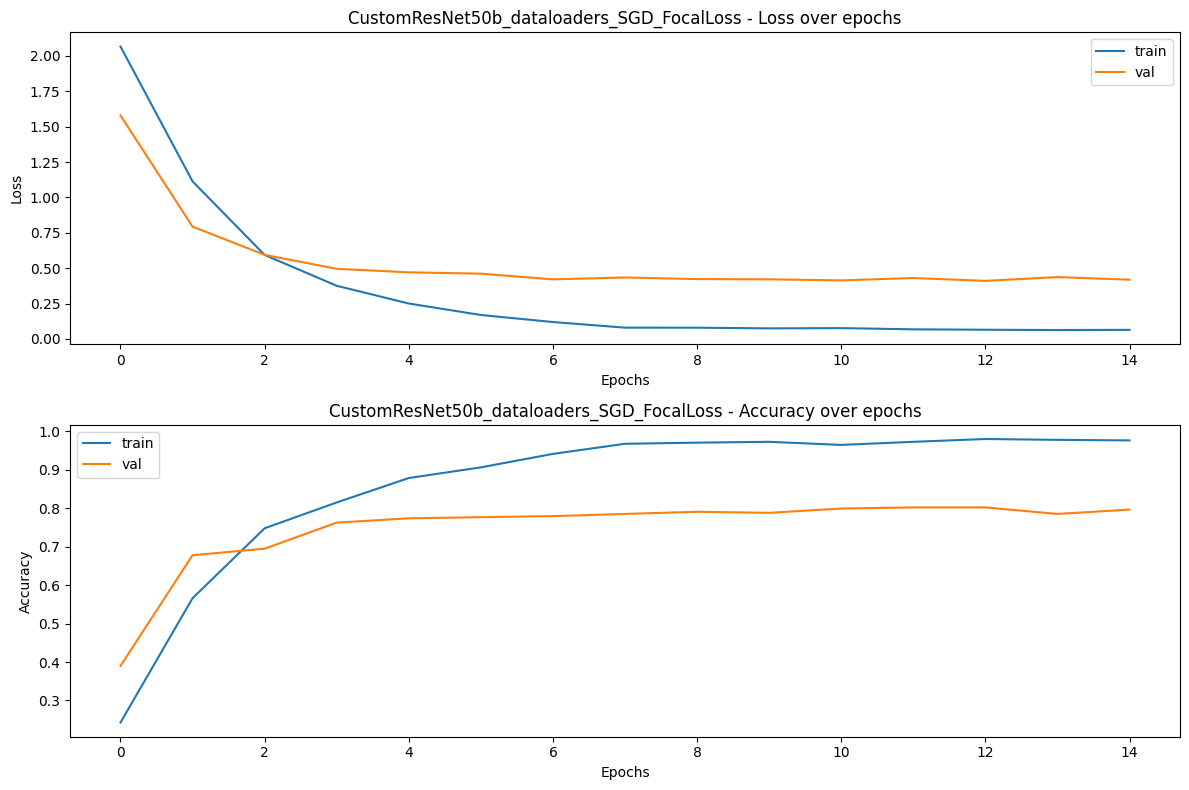


Training with CustomResNet50b, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7ffaab317790>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7ffaab317850>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7ffaab317460>}, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 2.0249 Acc: 0.3287
val Loss: 23.0709 Acc: 0.0734

Epoch 1/14
----------
train Loss: 1.5678 Acc: 0.4434
val Loss: 1.6865 Acc: 0.3927

Epoch 2/14
----------
train Loss: 1.3864 Acc: 0.5194
val Loss: 1.4404 Acc: 0.4774

Epoch 3/14
----------
train Loss: 1.2050 Acc: 0.5654
val Loss: 1.5347 Acc: 0.5085

Epoch 4/14
----------
train Loss: 1.1778 Acc: 0.5829
val Loss: 2.0283 Acc: 0.4831

Epoch 5/14
----------
train Loss: 1.1577 Acc: 0.5968
val Loss: 1.3491 Acc: 0.5311

Epoch 6/14
----------
train Loss: 1.0090 Acc: 0.6392
val Loss: 1.3533 Acc: 0.5847

Epoch 7/14
----------
train Loss: 0.8591 Acc: 0.7012
val Loss: 1.2071 Acc: 0.6554

Epoch 8/14
----------
train Loss: 0.7764 Acc: 0.7290


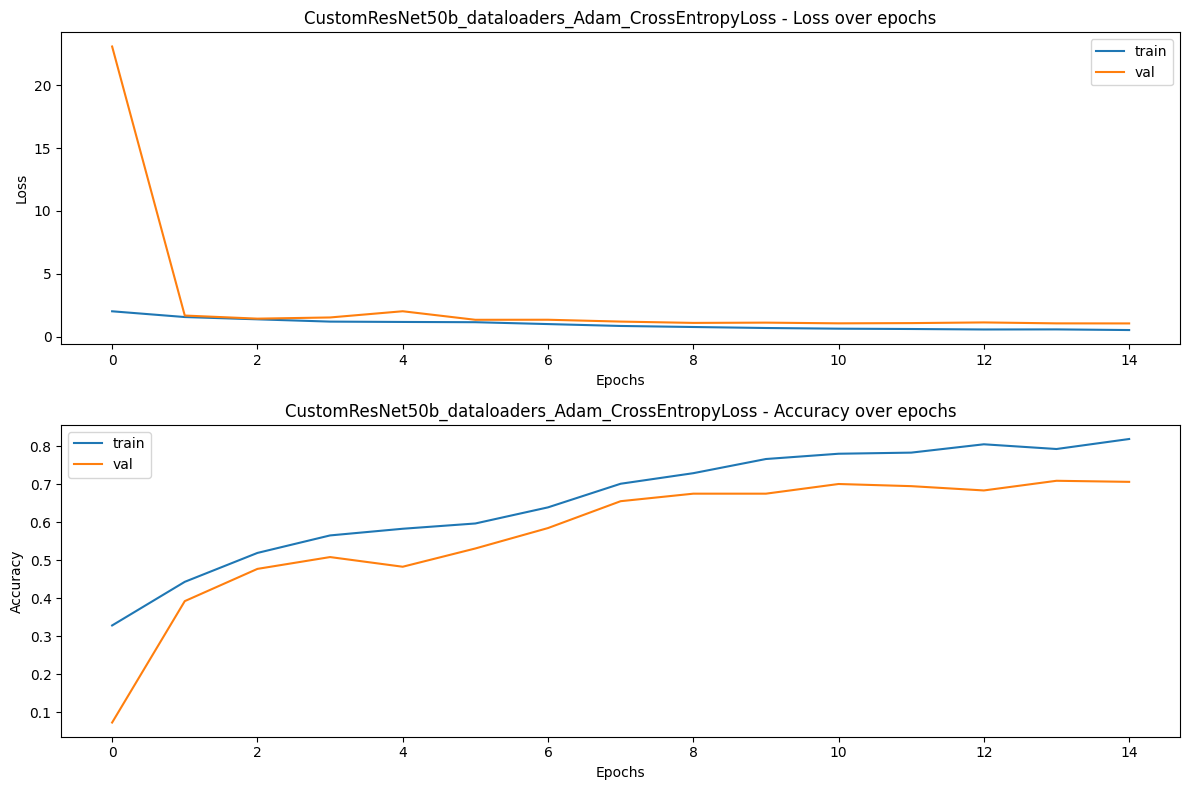


Training with CustomResNet50b, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7ffaab317790>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7ffaab317850>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7ffaab317460>}, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.4946 Acc: 0.3514
val Loss: 3.4363 Acc: 0.2825

Epoch 1/14
----------
train Loss: 0.9536 Acc: 0.4785
val Loss: 1.3223 Acc: 0.4435

Epoch 2/14
----------
train Loss: 0.8366 Acc: 0.5332
val Loss: 1.1319 Acc: 0.5085

Epoch 3/14
----------
train Loss: 0.7557 Acc: 0.5588
val Loss: 1.1884 Acc: 0.4746

Epoch 4/14
----------
train Loss: 0.6770 Acc: 0.6012
val Loss: 1.3742 Acc: 0.4605

Epoch 5/14
----------
train Loss: 0.6250 Acc: 0.6056
val Loss: 1.6032 Acc: 0.4153

Epoch 6/14
----------
train Loss: 0.6074 Acc: 0.6129
val Loss: 1.5926 Acc: 0.4124

Epoch 7/14
----------
train Loss: 0.4207 Acc: 0.6983
val Loss: 0.6943 Acc: 0.6525

Epoch 8/14
----------
train Loss: 0.3563 Acc: 0.7443
val Loss

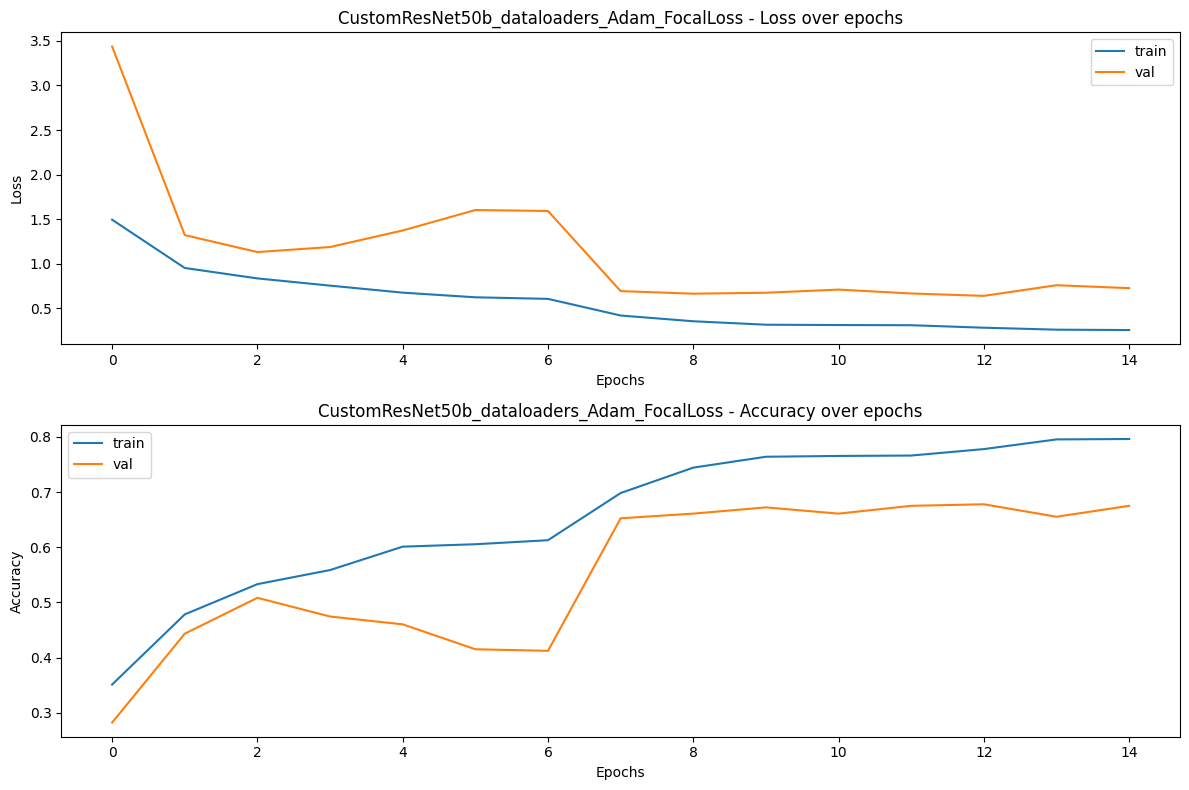


Training with CustomResNet50b, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7ffaa3ad1ab0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7ffaa3ad0490>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7ffaa3f51f00>}, SGD, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 2.5503 Acc: 0.1972
val Loss: 2.2022 Acc: 0.3079

Epoch 1/14
----------
train Loss: 1.8328 Acc: 0.4587
val Loss: 1.5270 Acc: 0.6073

Epoch 2/14
----------
train Loss: 1.2563 Acc: 0.6333
val Loss: 1.0884 Acc: 0.6836

Epoch 3/14
----------
train Loss: 0.8974 Acc: 0.7232
val Loss: 0.9537 Acc: 0.6949

Epoch 4/14
----------
train Loss: 0.6740 Acc: 0.7896
val Loss: 0.8120 Acc: 0.7373

Epoch 5/14
----------
train Loss: 0.5147 Acc: 0.8481
val Loss: 0.7021 Acc: 0.7797

Epoch 6/14
----------
train Loss: 0.3930 Acc: 0.8831
val Loss: 0.6448 Acc: 0.7853

Epoch 7/14
----------
train Loss: 0.3026 Acc: 0.9138
val Loss: 0.6439 Acc: 0.8051

Epoch 8/14
----------
train Loss: 0.2829 Acc: 0.9284
va

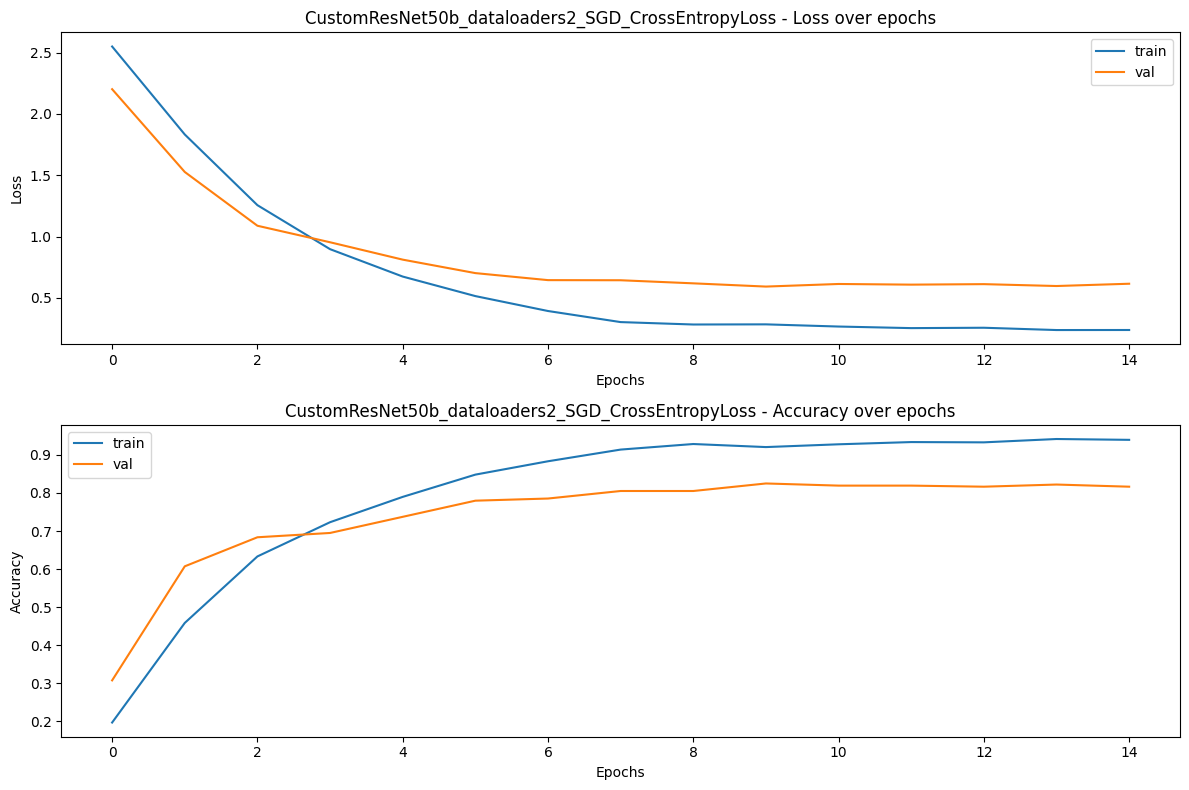


Training with CustomResNet50b, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7ffaa3ad1ab0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7ffaa3ad0490>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7ffaa3f51f00>}, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 2.1223 Acc: 0.2235
val Loss: 1.6454 Acc: 0.3559

Epoch 1/14
----------
train Loss: 1.2361 Acc: 0.5230
val Loss: 0.8641 Acc: 0.6412

Epoch 2/14
----------
train Loss: 0.7176 Acc: 0.6669
val Loss: 0.5803 Acc: 0.7260

Epoch 3/14
----------
train Loss: 0.4442 Acc: 0.7896
val Loss: 0.5247 Acc: 0.7260

Epoch 4/14
----------
train Loss: 0.3116 Acc: 0.8313
val Loss: 0.4535 Acc: 0.7627

Epoch 5/14
----------
train Loss: 0.2454 Acc: 0.8619
val Loss: 0.3912 Acc: 0.7825

Epoch 6/14
----------
train Loss: 0.1840 Acc: 0.9014
val Loss: 0.3989 Acc: 0.7825

Epoch 7/14
----------
train Loss: 0.1385 Acc: 0.9277
val Loss: 0.3946 Acc: 0.7825

Epoch 8/14
----------
train Loss: 0.1232 Acc: 0.9394
val Loss:

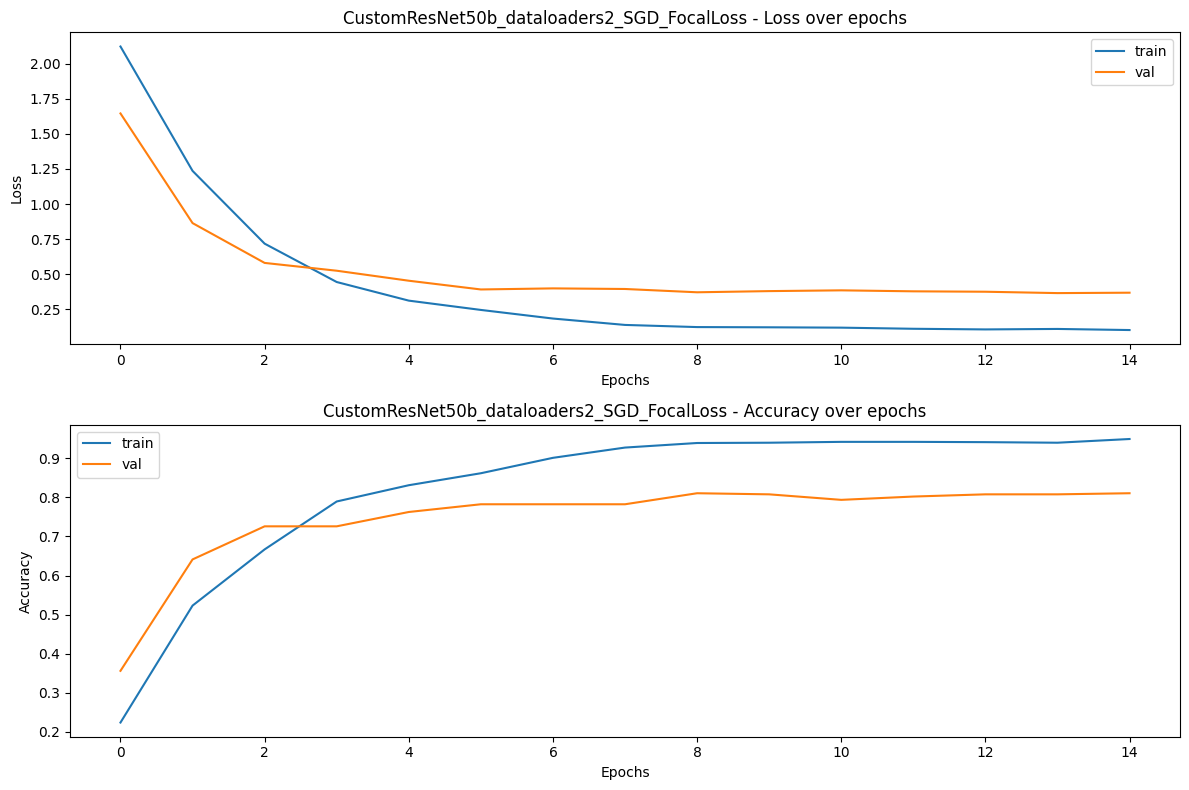


Training with CustomResNet50b, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7ffaa3ad1ab0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7ffaa3ad0490>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7ffaa3f51f00>}, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 2.2481 Acc: 0.2644
val Loss: 2.1542 Acc: 0.2910

Epoch 1/14
----------
train Loss: 1.7370 Acc: 0.3981
val Loss: 1.9924 Acc: 0.3418

Epoch 2/14
----------
train Loss: 1.4416 Acc: 0.4989
val Loss: 1.6272 Acc: 0.4237

Epoch 3/14
----------
train Loss: 1.3720 Acc: 0.5164
val Loss: 1.6575 Acc: 0.4350

Epoch 4/14
----------
train Loss: 1.2449 Acc: 0.5296
val Loss: 1.4707 Acc: 0.5000

Epoch 5/14
----------
train Loss: 1.2058 Acc: 0.5646
val Loss: 1.5684 Acc: 0.4774

Epoch 6/14
----------
train Loss: 1.1022 Acc: 0.5836
val Loss: 1.5957 Acc: 0.4181

Epoch 7/14
----------
train Loss: 0.9498 Acc: 0.6370
val Loss: 1.1349 Acc: 0.5904

Epoch 8/14
----------
train Loss: 0.8614 Acc: 0.6830
v

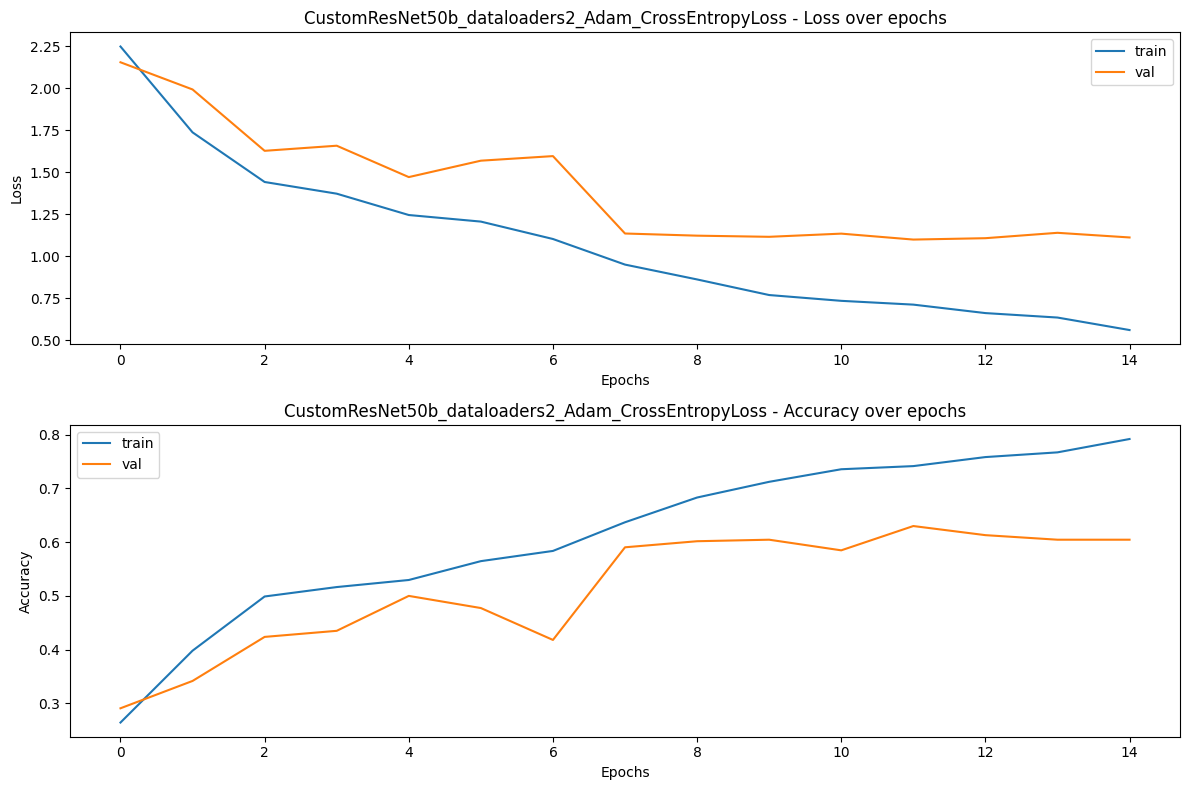


Training with CustomResNet50b, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7ffaa3ad1ab0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7ffaa3ad0490>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7ffaa3f51f00>}, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.8437 Acc: 0.2447
val Loss: 1.8211 Acc: 0.2232

Epoch 1/14
----------
train Loss: 1.3056 Acc: 0.3696
val Loss: 1.2897 Acc: 0.3898

Epoch 2/14
----------
train Loss: 1.0750 Acc: 0.4449
val Loss: 1.3584 Acc: 0.3814

Epoch 3/14
----------
train Loss: 0.9621 Acc: 0.4792
val Loss: 1.1166 Acc: 0.4209

Epoch 4/14
----------
train Loss: 0.8651 Acc: 0.5164
val Loss: 2.0400 Acc: 0.2571

Epoch 5/14
----------
train Loss: 0.7961 Acc: 0.5522
val Loss: 1.2344 Acc: 0.4718

Epoch 6/14
----------
train Loss: 0.7403 Acc: 0.5690
val Loss: 2.8935 Acc: 0.2684

Epoch 7/14
----------
train Loss: 0.6324 Acc: 0.6107
val Loss: 0.7651 Acc: 0.5763

Epoch 8/14
----------
train Loss: 0.5247 Acc: 0.6837
val Loss

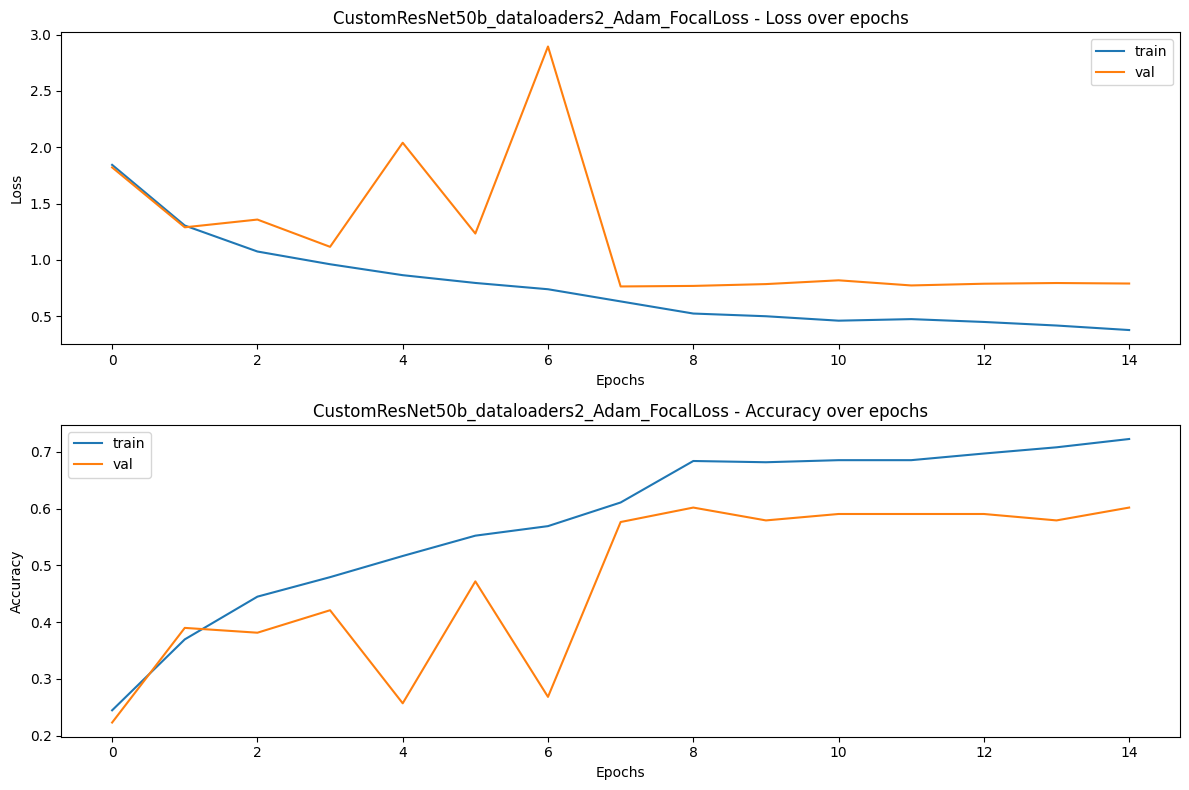


Training with CustomDenseNet, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7ffaab317790>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7ffaab317850>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7ffaab317460>}, SGD, CrossEntropyLoss


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 78.6MB/s]


Epoch 0/14
----------
train Loss: 1.8291 Acc: 0.4843
val Loss: 1.1622 Acc: 0.6469

Epoch 1/14
----------
train Loss: 0.8554 Acc: 0.7706
val Loss: 0.8194 Acc: 0.7429

Epoch 2/14
----------
train Loss: 0.5284 Acc: 0.8546
val Loss: 0.6734 Acc: 0.8023

Epoch 3/14
----------
train Loss: 0.4129 Acc: 0.8912
val Loss: 0.6384 Acc: 0.7910

Epoch 4/14
----------
train Loss: 0.2571 Acc: 0.9379
val Loss: 0.5423 Acc: 0.8249

Epoch 5/14
----------
train Loss: 0.1860 Acc: 0.9664
val Loss: 0.5377 Acc: 0.8249

Epoch 6/14
----------
train Loss: 0.1279 Acc: 0.9781
val Loss: 0.5415 Acc: 0.8305

Epoch 7/14
----------
train Loss: 0.0921 Acc: 0.9876
val Loss: 0.5201 Acc: 0.8333

Epoch 8/14
----------
train Loss: 0.0993 Acc: 0.9861
val Loss: 0.5135 Acc: 0.8362

Epoch 9/14
----------
train Loss: 0.0932 Acc: 0.9905
val Loss: 0.5215 Acc: 0.8305

Epoch 10/14
----------
train Loss: 0.0794 Acc: 0.9927
val Loss: 0.5277 Acc: 0.8249

Epoch 11/14
----------
train Loss: 0.0787 Acc: 0.9942
val Loss: 0.5275 Acc: 0.8333

Ep

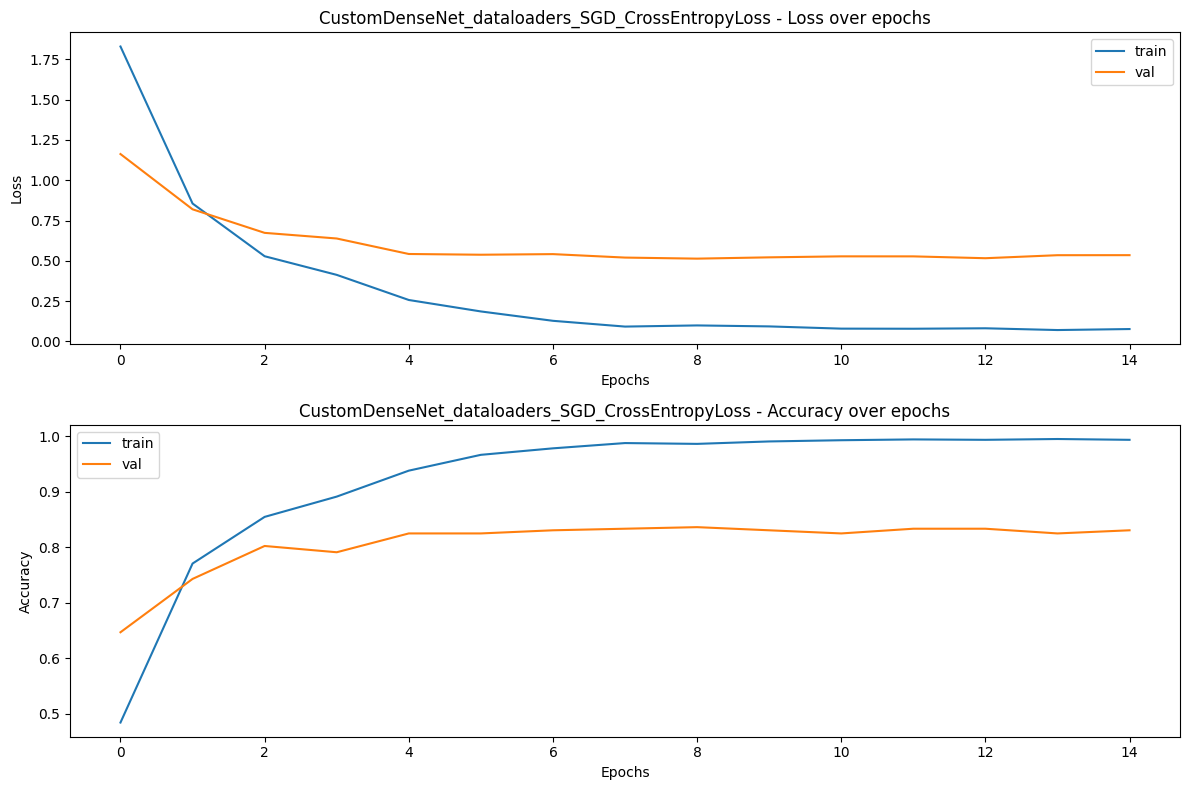


Training with CustomDenseNet, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7ffaab317790>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7ffaab317850>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7ffaab317460>}, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 1.3914 Acc: 0.4741
val Loss: 0.6989 Acc: 0.6977

Epoch 1/14
----------
train Loss: 0.4384 Acc: 0.8064
val Loss: 0.4842 Acc: 0.7768

Epoch 2/14
----------
train Loss: 0.2507 Acc: 0.8802
val Loss: 0.4865 Acc: 0.7627

Epoch 3/14
----------
train Loss: 0.1527 Acc: 0.9218
val Loss: 0.4184 Acc: 0.8023

Epoch 4/14
----------
train Loss: 0.0841 Acc: 0.9701
val Loss: 0.3597 Acc: 0.8192

Epoch 5/14
----------
train Loss: 0.0562 Acc: 0.9795
val Loss: 0.3653 Acc: 0.8333

Epoch 6/14
----------
train Loss: 0.0512 Acc: 0.9803
val Loss: 0.3800 Acc: 0.8079

Epoch 7/14
----------
train Loss: 0.0305 Acc: 0.9942
val Loss: 0.3735 Acc: 0.8192

Epoch 8/14
----------
train Loss: 0.0377 Acc: 0.9898
val Loss: 

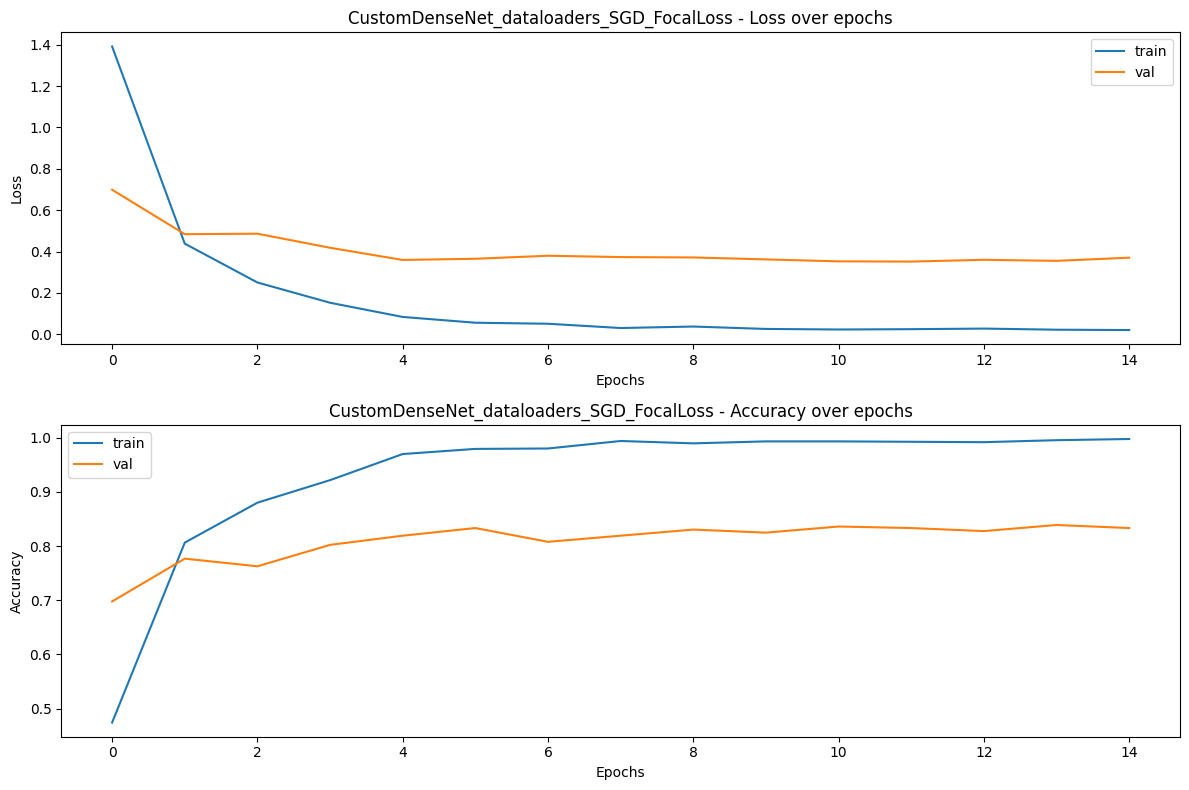


Training with CustomDenseNet, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7ffaab317790>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7ffaab317850>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7ffaab317460>}, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.2864 Acc: 0.6041
val Loss: 1.5804 Acc: 0.5537

Epoch 1/14
----------
train Loss: 0.7552 Acc: 0.7677
val Loss: 1.1398 Acc: 0.6045

Epoch 2/14
----------
train Loss: 0.5744 Acc: 0.8101
val Loss: 1.8452 Acc: 0.5424

Epoch 3/14
----------
train Loss: 0.4860 Acc: 0.8517
val Loss: 1.0757 Acc: 0.6723

Epoch 4/14
----------
train Loss: 0.4154 Acc: 0.8598
val Loss: 0.7297 Acc: 0.7797

Epoch 5/14
----------
train Loss: 0.3171 Acc: 0.8934
val Loss: 1.2329 Acc: 0.6808

Epoch 6/14
----------
train Loss: 0.2946 Acc: 0.9028
val Loss: 0.9743 Acc: 0.7627

Epoch 7/14
----------
train Loss: 0.1531 Acc: 0.9533
val Loss: 0.4994 Acc: 0.8475

Epoch 8/14
----------
train Loss: 0.0959 Acc: 0.9752
va

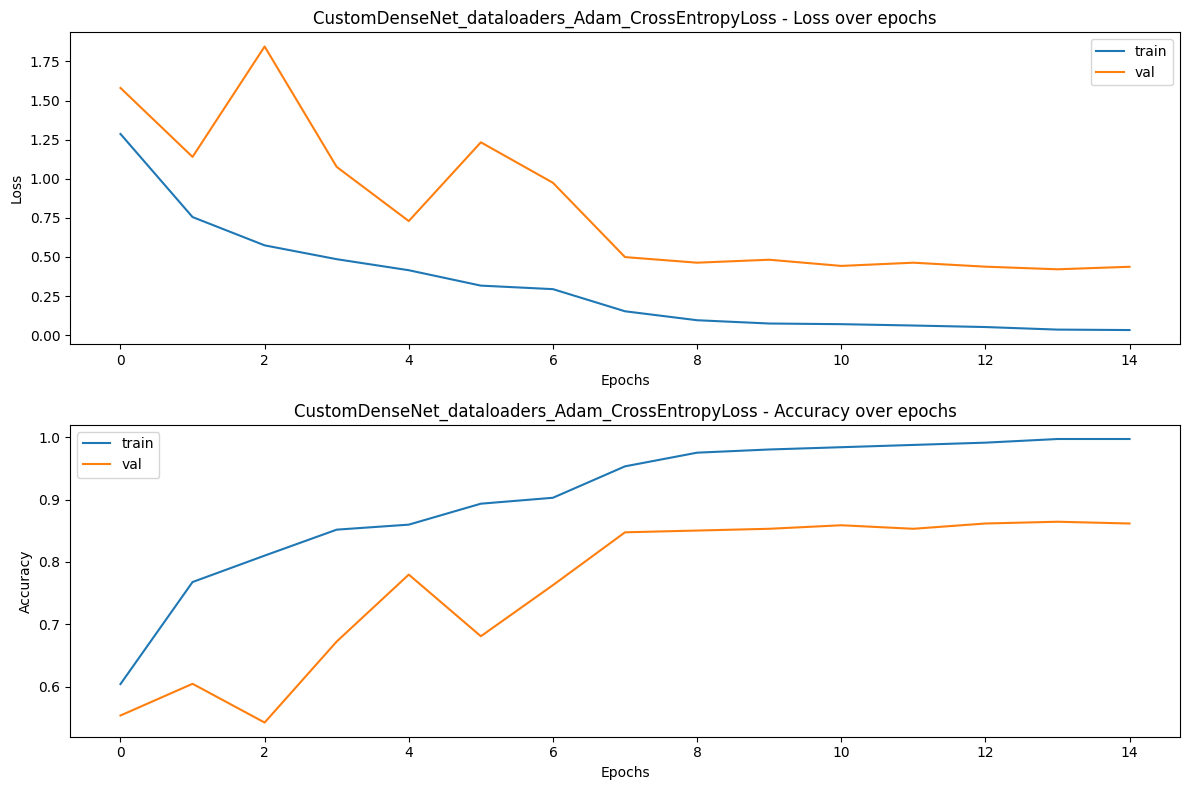


Training with CustomDenseNet, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7ffaab317790>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7ffaab317850>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7ffaab317460>}, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 0.9646 Acc: 0.5676
val Loss: 2.4733 Acc: 0.3842

Epoch 1/14
----------
train Loss: 0.5129 Acc: 0.7443
val Loss: 0.4837 Acc: 0.7345

Epoch 2/14
----------
train Loss: 0.3573 Acc: 0.7911
val Loss: 0.7169 Acc: 0.7034

Epoch 3/14
----------
train Loss: 0.2853 Acc: 0.8210
val Loss: 0.7046 Acc: 0.6864

Epoch 4/14
----------
train Loss: 0.2816 Acc: 0.8174
val Loss: 0.5222 Acc: 0.7655

Epoch 5/14
----------
train Loss: 0.1881 Acc: 0.8766
val Loss: 0.4851 Acc: 0.7401

Epoch 6/14
----------
train Loss: 0.1551 Acc: 0.8890
val Loss: 1.1665 Acc: 0.6073

Epoch 7/14
----------
train Loss: 0.0961 Acc: 0.9313
val Loss: 0.3707 Acc: 0.8164

Epoch 8/14
----------
train Loss: 0.0422 Acc: 0.9737
val Loss:

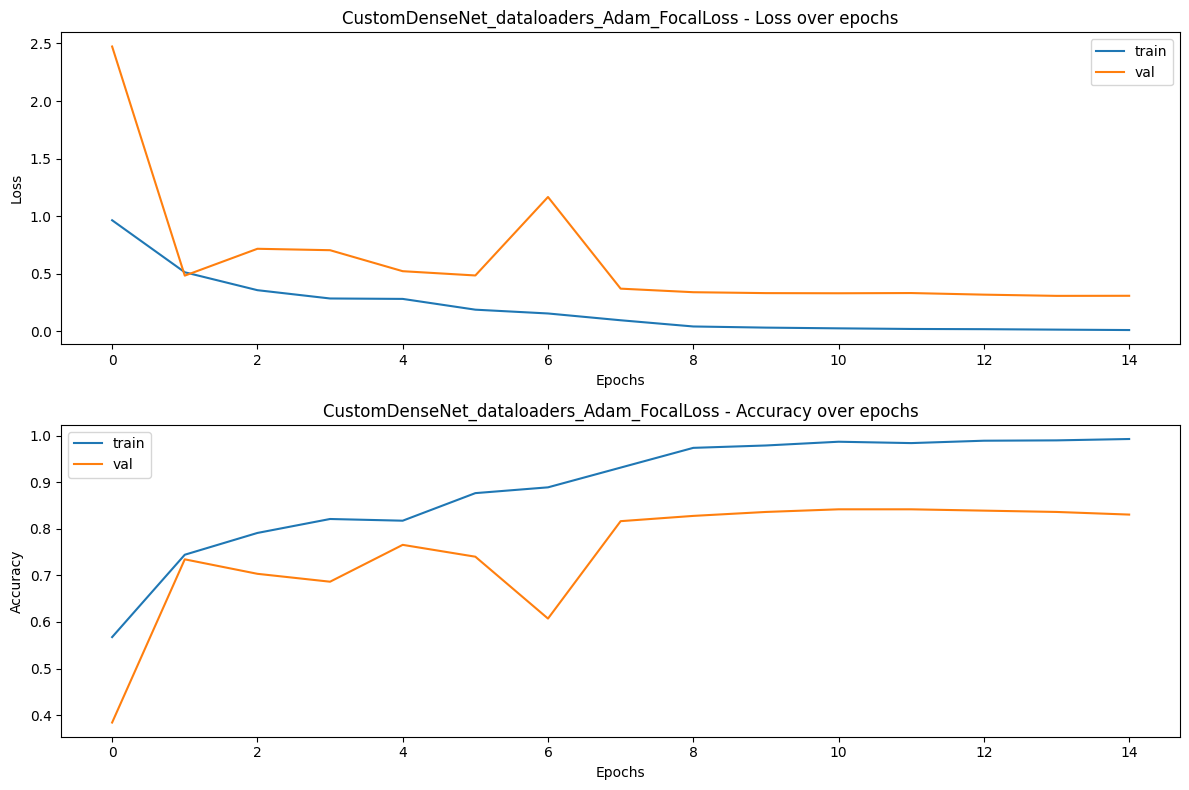


Training with CustomDenseNet, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7ffaa3ad1ab0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7ffaa3ad0490>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7ffaa3f51f00>}, SGD, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 2.0108 Acc: 0.4069
val Loss: 1.2199 Acc: 0.6836

Epoch 1/14
----------
train Loss: 1.0125 Acc: 0.7093
val Loss: 0.8880 Acc: 0.7175

Epoch 2/14
----------
train Loss: 0.6581 Acc: 0.8159
val Loss: 0.6932 Acc: 0.7910

Epoch 3/14
----------
train Loss: 0.4653 Acc: 0.8663
val Loss: 0.5794 Acc: 0.8277

Epoch 4/14
----------
train Loss: 0.3456 Acc: 0.9021
val Loss: 0.5580 Acc: 0.8305

Epoch 5/14
----------
train Loss: 0.2654 Acc: 0.9284
val Loss: 0.5221 Acc: 0.8418

Epoch 6/14
----------
train Loss: 0.1993 Acc: 0.9547
val Loss: 0.4825 Acc: 0.8418

Epoch 7/14
----------
train Loss: 0.1464 Acc: 0.9715
val Loss: 0.4876 Acc: 0.8333

Epoch 8/14
----------
train Loss: 0.1434 Acc: 0.9810
val

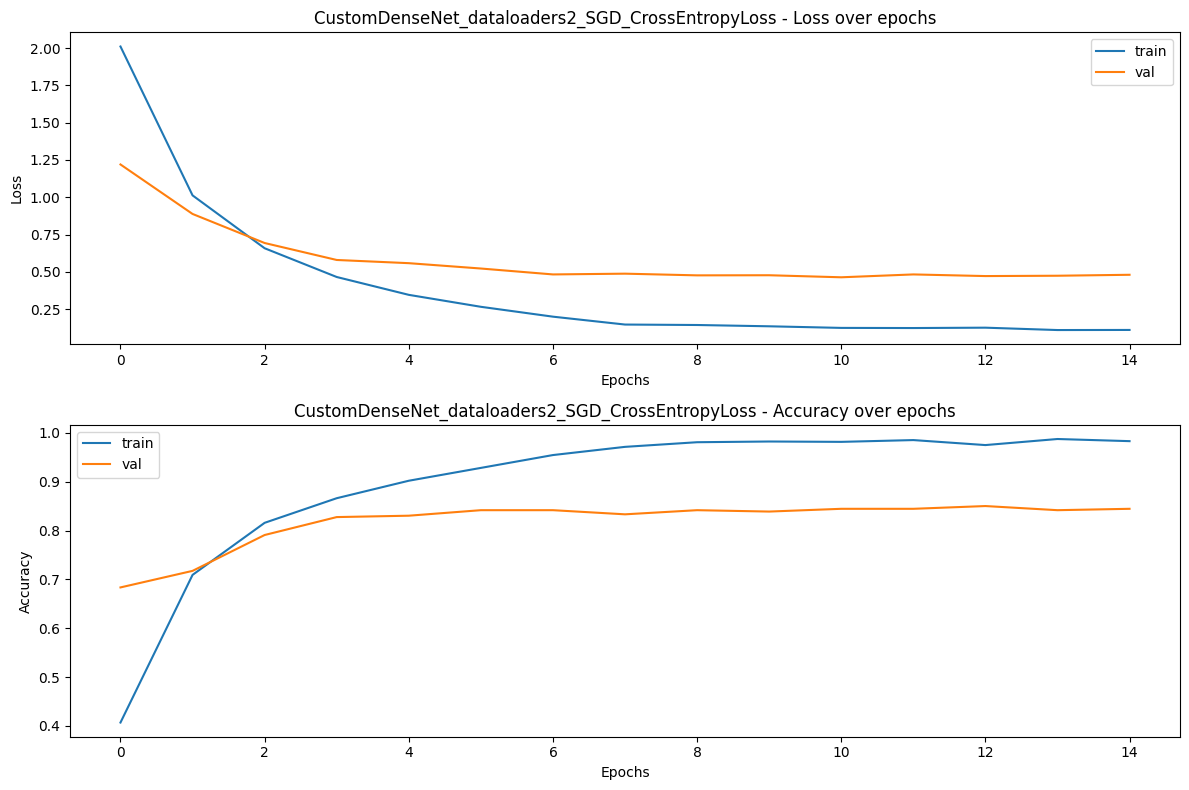


Training with CustomDenseNet, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7ffaa3ad1ab0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7ffaa3ad0490>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7ffaa3f51f00>}, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 1.4125 Acc: 0.4631
val Loss: 0.7730 Acc: 0.6525

Epoch 1/14
----------
train Loss: 0.5311 Acc: 0.7480
val Loss: 0.5232 Acc: 0.7232

Epoch 2/14
----------
train Loss: 0.3281 Acc: 0.8364
val Loss: 0.4503 Acc: 0.7486

Epoch 3/14
----------
train Loss: 0.2092 Acc: 0.8897
val Loss: 0.3893 Acc: 0.7966

Epoch 4/14
----------
train Loss: 0.1517 Acc: 0.9204
val Loss: 0.3587 Acc: 0.8051

Epoch 5/14
----------
train Loss: 0.1070 Acc: 0.9496
val Loss: 0.3681 Acc: 0.8079

Epoch 6/14
----------
train Loss: 0.0777 Acc: 0.9496
val Loss: 0.3573 Acc: 0.7910

Epoch 7/14
----------
train Loss: 0.0677 Acc: 0.9657
val Loss: 0.3661 Acc: 0.8107

Epoch 8/14
----------
train Loss: 0.0519 Acc: 0.9722
val Loss: 

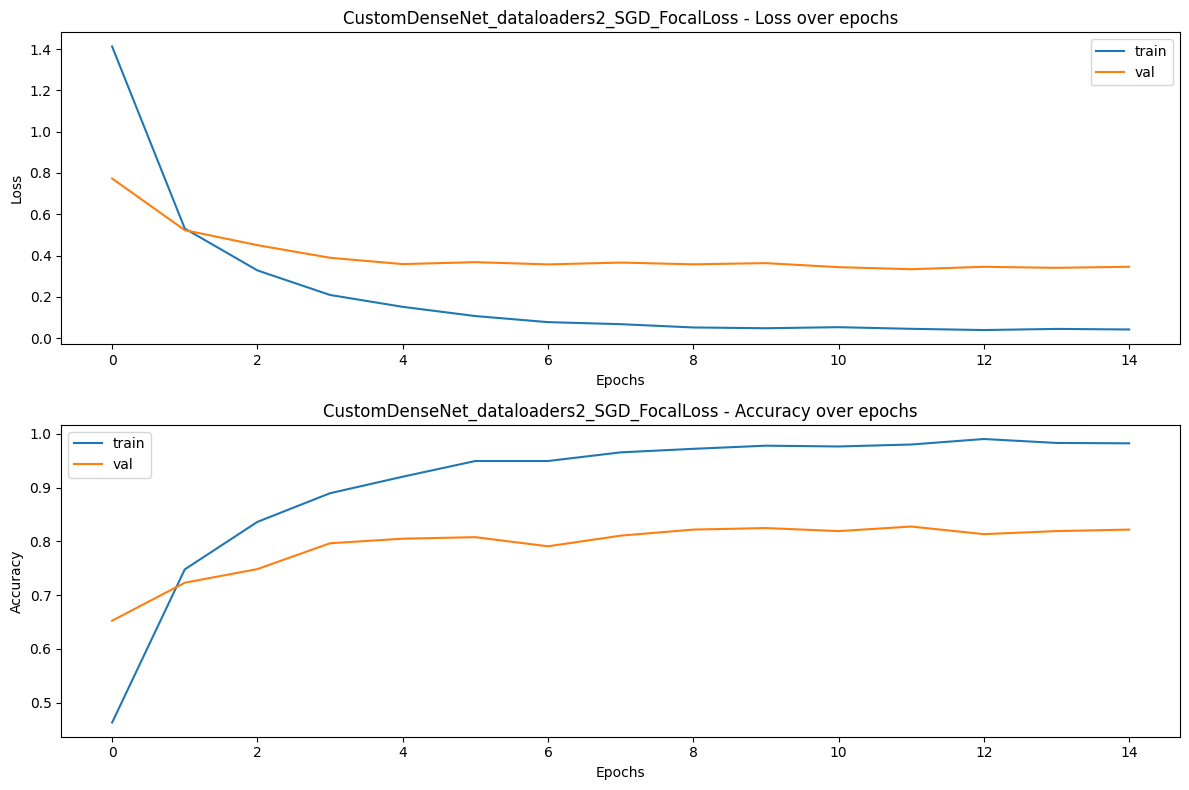


Training with CustomDenseNet, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7ffaa3ad1ab0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7ffaa3ad0490>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7ffaa3f51f00>}, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.3230 Acc: 0.5822
val Loss: 1.0587 Acc: 0.6667

Epoch 1/14
----------
train Loss: 0.8952 Acc: 0.6961
val Loss: 1.1994 Acc: 0.6441

Epoch 2/14
----------
train Loss: 0.6878 Acc: 0.7772
val Loss: 1.0157 Acc: 0.6751

Epoch 3/14
----------
train Loss: 0.5658 Acc: 0.8167
val Loss: 0.9434 Acc: 0.6893

Epoch 4/14
----------
train Loss: 0.4943 Acc: 0.8364
val Loss: 0.8530 Acc: 0.7090

Epoch 5/14
----------
train Loss: 0.4683 Acc: 0.8269
val Loss: 1.4108 Acc: 0.6610

Epoch 6/14
----------
train Loss: 0.4098 Acc: 0.8612
val Loss: 0.9190 Acc: 0.7232

Epoch 7/14
----------
train Loss: 0.2389 Acc: 0.9233
val Loss: 0.4866 Acc: 0.8305

Epoch 8/14
----------
train Loss: 0.1484 Acc: 0.9598
va

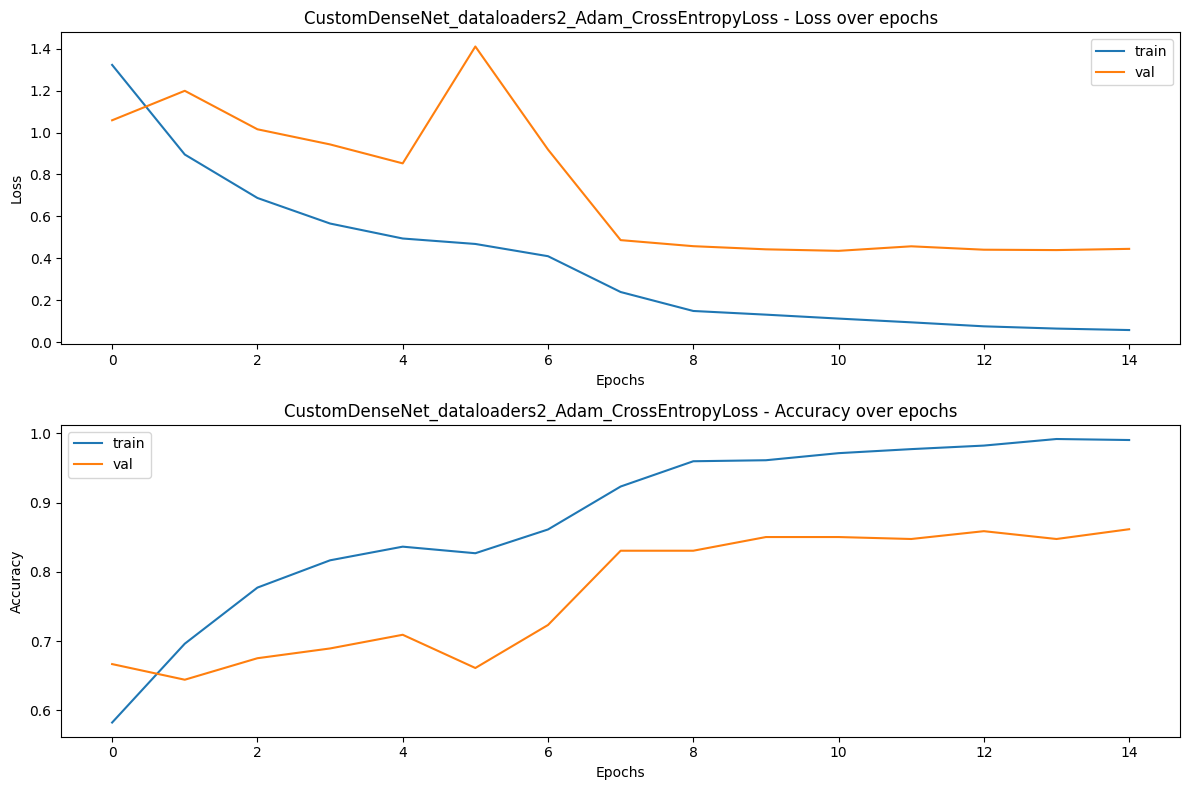


Training with CustomDenseNet, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7ffaa3ad1ab0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7ffaa3ad0490>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7ffaa3f51f00>}, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.0435 Acc: 0.5566
val Loss: 1.1222 Acc: 0.4887

Epoch 1/14
----------
train Loss: 0.5790 Acc: 0.6874
val Loss: 0.9649 Acc: 0.5989

Epoch 2/14
----------
train Loss: 0.4941 Acc: 0.7056
val Loss: 1.0549 Acc: 0.6271

Epoch 3/14
----------
train Loss: 0.3483 Acc: 0.7977
val Loss: 0.7526 Acc: 0.6808

Epoch 4/14
----------
train Loss: 0.2461 Acc: 0.8495
val Loss: 0.6517 Acc: 0.7288

Epoch 5/14
----------
train Loss: 0.2382 Acc: 0.8481
val Loss: 0.4495 Acc: 0.7684

Epoch 6/14
----------
train Loss: 0.2411 Acc: 0.8408
val Loss: 0.4539 Acc: 0.7655

Epoch 7/14
----------
train Loss: 0.1170 Acc: 0.9218
val Loss: 0.3377 Acc: 0.8362

Epoch 8/14
----------
train Loss: 0.0652 Acc: 0.9438
val Loss:

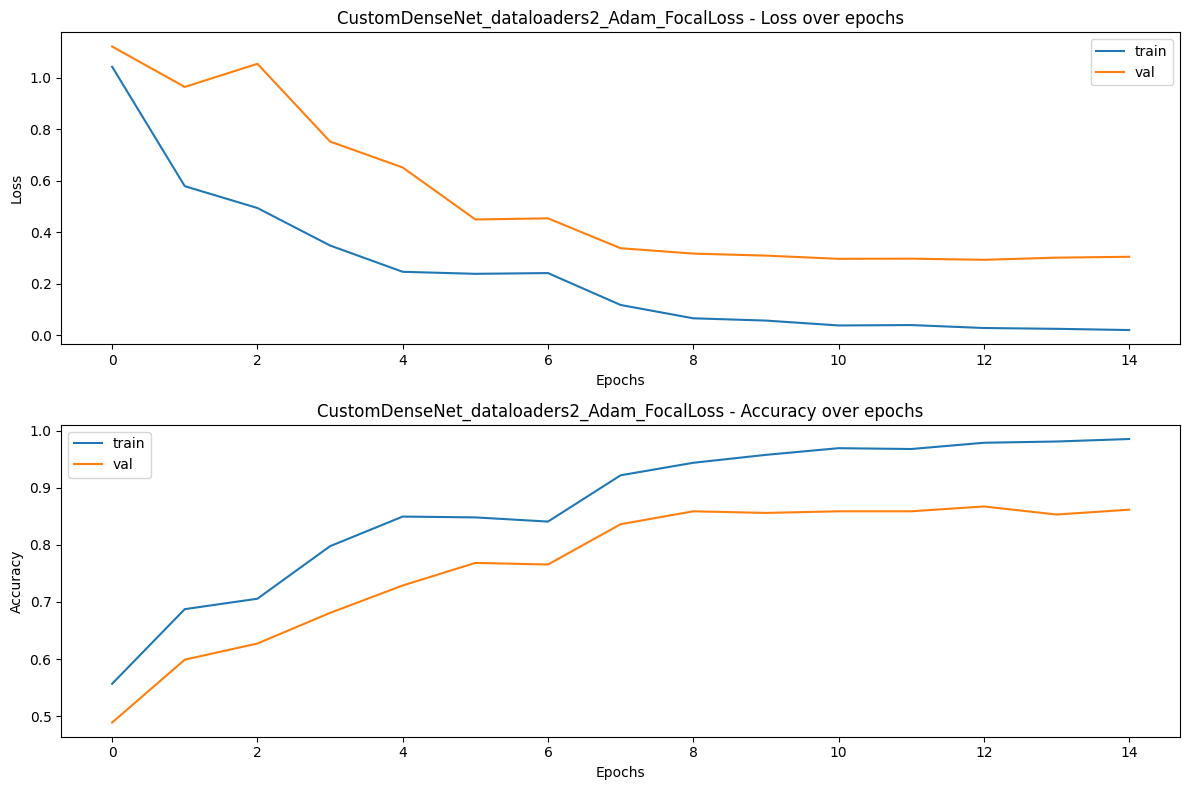

In [10]:
# perform several training runs to compare accuracy on the validation dataset
best_model = None
best_accuracy = -1

for model_class in models:
  for loader in loaders:
        for opt in optimizers:
            for loss_func_class in loss_funcs:
                print(f"\nTraining with {model_class.__name__}, {loaders_dict[loader]}, {opt}, {loss_func_class.__name__}")

                # Instantiate the custom model
                num_classes = len(classes)
                model = model_class(num_classes)
                model = model.to(device)  # Move the model to the appropriate device

                # Define loss function 
                criterion = loss_func_class()
               
                # Instantiate the selected optimizer with its parameters
                opt_class = optim_dict[opt]['class']
                opt_params = optim_dict[opt]['params']
                optimizer = opt_class(model.parameters(), **opt_params)
               
                #optimizer = opt_class(model.parameters(), lr=0.001, momentum=0.9)

                # Decay LR by a factor of 0.1 every 7 epochs
                exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

                # Select the dataloader
                dataloaders = loaders_dict[loader]

                # Train the model
                trained_model, best_val_accuracy, history = train_cnn_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

                # Print the history data
                print("Training loss history:", history['train_loss'])
                print("Validation loss history:", history['val_loss'])
                print("Training accuracy history:", history['train_acc'])
                print("Validation accuracy history:", history['val_acc'])


                # Plot training curves
                combination_name = f"{model_class.__name__}_{loaders_dict[loader]}_{opt}_{loss_func_class.__name__}"
                plot_training_curves(history, combination_name)

                if best_val_accuracy > best_accuracy:
                  best_model = trained_model
                  best_accuracy = best_val_accuracy
               

In [11]:
def display_and_save_results2(y_pred, y_true, classes=classes, fn='', saveflag = True):
   

    classes_raw_list = np.unique(np.concatenate((y_true, y_pred)))
    print(classes_raw_list)
    classes_list = [classes[x] for x in classes_raw_list]
    print(classes_list)
    y_true = [classes[x] for x in y_true]
    y_pred = [classes[x] for x in y_pred]
    # Generate a confusion matrix based on the true labels and predicted labels
    cm = confusion_matrix(y_true = y_true, y_pred = y_pred, labels=classes_list)
  
    #mask = np.all(cm == 0, axis=1)

    class_text_labels = np.array([abd_label_dict[str(x)]['short'] for x in classes_list])
    #class_text_labels = class_text_labels[~mask]

     # Generate a classification report based on the true labels and predicted labels
    print(classification_report(y_true, y_pred))

    
    #cm = cm[~mask]
    # Create a ConfusionMatrixDisplay object with the correct labels
    cm_display = ConfusionMatrixDisplay(cm, display_labels=class_text_labels).plot(xticks_rotation = 'vertical', cmap='Blues')
    plt.figure(figsize=(25, 25))
    plt.tight_layout()
    #ConfusionMatrixDisplay(cm, display_labels=class_text_labels).plot(xticks_rotation = 'vertical', cmap='Blues')
    if saveflag:
        plt.savefig("../assets/FigCM_"+fn+datetime.today().strftime('%Y%m%d')+".tif",dpi=300, bbox_inches = 'tight')     

    return cm      



[ 0  1  2  3  4  5  7  8  9 10 12 13 14 15 17 18]
[0, 2, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 23, 25]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           2       0.83      0.88      0.85        49
           6       0.88      1.00      0.93        14
           7       0.90      1.00      0.95        18
           8       0.95      1.00      0.97        35
           9       1.00      0.94      0.97        34
          11       1.00      0.95      0.97        20
          12       0.00      0.00      0.00        12
          13       1.00      0.33      0.50         3
          14       1.00      0.89      0.94        19
          16       0.55      0.60      0.57        20
          17       1.00      0.94      0.97        17
          18       1.00      0.91      0.95        22
          19       1.00      0.89      0.94        19
          23       0.50      0.53      0.51        19
          25       0.75   

FileNotFoundError: ignored

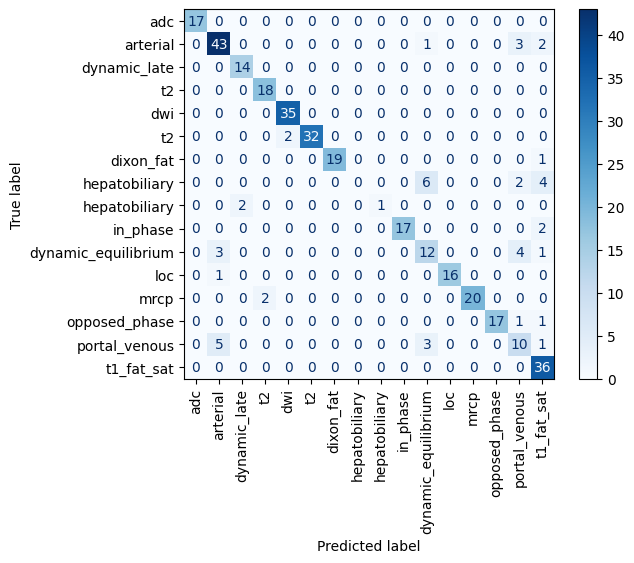

<Figure size 2500x2500 with 0 Axes>

In [12]:
# Evaluate the model on the val dataset
model = best_model

model.eval()
val_predictions = []
val_labels = []

for inputs, labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad(): # No need to calculate gradients when doing inference
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1) # Get class from network's prediction
        val_predictions.append(predicted.cpu().numpy())
        val_labels.append(labels.cpu().numpy())
val_predictions = np.concatenate(val_predictions, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

#print(val_predictions)
#print(val_labels)
cm = display_and_save_results2(val_predictions, val_labels, classes, fn='DenseNetFL', saveflag=True)

# Save the trained model if needed
save_filename = f"cnn_model_{combination_name}_{datetime.now().strftime('%Y%m%d')}.pth"
torch.save(trained_model.state_dict(), save_filename)



# model.eval()
# val_predictions = []
# test_labels = []

# for inputs, labels in test_loader:
#     inputs = inputs.to(device)
#     labels = labels.to(device)
#     print(labels)
#     with torch.no_grad(): # No need to calculate gradients when doing inference
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs, 1) # Get class from network's prediction
#         test_predictions.append(predicted.cpu().numpy())
#         test_labels.append(labels.cpu().numpy())

# print (test_predictions)
# print(test_labels)


# test_predictions = np.concatenate(test_predictions, axis=0)
# test_labels = np.concatenate(test_labels, axis=0)


# accuracy = np.sum(test_predictions==test_labels)/len(test_labels)
# print('Accuracy on the test dataset is ', np.round(accuracy, 3))
# #results = make_results_df(preds, true, test)

# # Save the trained model if needed
# save_filename = f"cnn_model_{combination_name}_{datetime.now().strftime('%Y%m%d')}.pth"
# torch.save(trained_model.state_dict(), save_filename)


In [ ]:
pip install transformers
from transformers import DeiTFeatureExtractor, DeiTForImageClassification



In [ ]:
model = DeiTForImageClassification.from_pretrained('facebook/deit-base-distilled-patch16-224')
feature_extractor = DeiTFeatureExtractor.from_pretrained('facebook/deit-base-distilled-patch16-224')

deit_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

